# 🏥 Disease-Specific Analysis: Medical Conditions Impact on Depression Treatment

## Comprehensive Medical Condition Analysis for Depression Prediction

**Objective:** Analyze how different medical conditions influence depression treatment outcomes using advanced GRU models and SHAP analysis

**Key Analysis Components:**
- 🔬 Medical Condition Prevalence & Impact Assessment
- 🎯 Disease-Specific Feature Importance using SHAP
- 📊 Condition-Stratified Outcome Analysis
- 🧠 GRU Model Performance by Medical Condition
- 💊 Treatment Response Patterns by Disease Groups
- 🎨 Interactive Medical Condition Visualizations

---
**Medical Conditions Analyzed:**
- Cardiovascular Conditions
- Metabolic Disorders  
- Musculoskeletal Conditions
- Respiratory Conditions
- Neurological Conditions
- Complex Multi-morbidity Patterns
---

In [3]:
# 📚 Import Essential Libraries for Disease-Specific Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Model Interpretation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Advanced SHAP Analysis
import shap

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kruskal, mannwhitneyu, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# File handling
import json
import pickle
from pathlib import Path
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting for beautiful static visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print("🚀 All libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🔬 Disease-Specific Analysis with Advanced SHAP Integration - STATIC PLOTS ONLY")

🚀 All libraries imported successfully!
📅 Analysis Date: 2025-10-01 13:35:57
🔬 Disease-Specific Analysis with Advanced SHAP Integration - STATIC PLOTS ONLY


In [4]:
# 📂 Load Corrected Dataset and Setup Paths
from pathlib import Path
import sys

# Setup paths for corrected data
current_dir = Path.cwd()
src_track1_path = current_dir if current_dir.name == 'SRC_Track1' else current_dir / 'SRC_Track1'
BASE_PATH = src_track1_path.parent
DATA_PATH = BASE_PATH / "Track1_Data" / "processed"
RESULTS_PATH = BASE_PATH / "Results_Corrected_Data"
FIGURES_PATH = BASE_PATH / "Reports" / "figures"

# Add SRC_Track1 to path for model imports
sys.path.append(str(BASE_PATH / "SRC_Track1"))

# Create directories if they don't exist
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

print(f"📁 Base Path: {BASE_PATH}")
print(f"📁 Data Path: {DATA_PATH}")
print(f"📁 Results Path: {RESULTS_PATH}")
print(f"📁 Figures Path: {FIGURES_PATH}")

# Load feature metadata if available
metadata_path = DATA_PATH / "feature_metadata.json"
if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        feature_metadata = json.load(f)
    print(f"✅ Loaded feature metadata: {len(feature_metadata)} features documented")
else:
    feature_metadata = {}
    print("⚠️ Feature metadata not found, will analyze available features")

# Load corrected training data
corrected_file = DATA_PATH / 'train_corrected_features.xlsx'
if corrected_file.exists():
    train_data = pd.read_excel(corrected_file)
    print(f"✅ Loaded corrected training data: {train_data.shape}")
else:
    print(f"❌ Corrected file not found: {corrected_file}")
    print("   Falling back to engineered features...")
    train_data = pd.read_excel(DATA_PATH / 'train_engineered_features.xlsx')
    print(f"⚠️ Using engineered data: {train_data.shape}")

# Load test data if available
test_file = DATA_PATH / 'test_split.xlsx'
if test_file.exists():
    test_data = pd.read_excel(test_file)
    print(f"✅ Test data loaded: {test_data.shape}")
else:
    test_data = None
    print("⚠️ Test data not found")

print(f"\n📊 Dataset Overview:")
print(f"   Training samples: {len(train_data)}")
print(f"   Dataset shape: {train_data.shape}")
print(f"   Test samples: {len(test_data) if test_data is not None else 0}")

# Define target columns and feature columns for corrected data
target_mapping = {
    '12w': 'bdi_ii_after_intervention_12w',
    '24w': 'bdi_ii_follow_up_24w'
}

# Check if target columns exist
available_targets = []
for period, col in target_mapping.items():
    if col in train_data.columns:
        available_targets.append((period, col))
        print(f"✅ Found target: {col}")
    else:
        print(f"❌ Missing target: {col}")

if not available_targets:
    print("⚠️ No target columns found with expected names, checking alternatives...")
    # Look for any BDI columns
    bdi_cols = [col for col in train_data.columns if 'bdi' in col.lower()]
    print(f"   Available BDI columns: {bdi_cols}")

# Identify medical condition features
condition_keywords = ['condition', 'disease', 'disorder', 'comorbid']
condition_features = [col for col in train_data.columns 
                     if any(keyword in col.lower() for keyword in condition_keywords)]

print(f"\n🏥 Medical Condition Features Found: {len(condition_features)}")
for condition in condition_features:
    print(f"   • {condition}")

# Get feature columns (exclude target variables and IDs)
excluded_cols = ['participant_id'] + list(target_mapping.values())
feature_cols = [col for col in train_data.columns if col not in excluded_cols]

print(f"\n🔧 Analysis Setup:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Condition features: {len(condition_features)}")
print(f"   Target variables: {[col for _, col in available_targets]}")

# Display target statistics
print(f"\n📈 Target Variable Statistics:")
for period, target_col in available_targets:
    if target_col in train_data.columns:
        stats = train_data[target_col].describe()
        print(f"   {target_col} ({period}): Mean={stats['mean']:.2f}, Std={stats['std']:.2f}, Range=[{stats['min']:.1f}, {stats['max']:.1f}]")

📁 Base Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN
📁 Data Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN\Track1_Data\processed
📁 Results Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN\Results_Corrected_Data
📁 Figures Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN\Reports\figures
✅ Loaded feature metadata: 7 features documented
✅ Loaded corrected training data: (167, 26)
✅ Test data loaded: (43, 10)

📊 Dataset Overview:
   Training samples: 167
   Dataset shape: (167, 26)
   Test samples: 43
✅ Found target: bdi_ii_after_intervention_12w
✅ Found target: bdi_ii_follow_up_24w

🏥 Medical Condition Features Found: 11
   • condition_cancer
   • condition_acute_coronary_syndrome
   • condition_renal_insufficiency
   • condition_lower_limb_amputation
   • condition_type_breast
   • condition_type_prostate
   • condition_type_revascularization
   • condition_type_no_prosthesis
   • condition_type_predialysis
   • condition_type_percutaneous_coronary_intervention
   • c

In [5]:
# 🤖 Pre-trained Model Loader System for Disease Analysis
# Import the experiment framework and phase modules to recreate models
from experiment_framework import ExperimentFramework
from phase1_baseline_models import Phase1BaselineModels
from phase2_classical_ml import Phase2ClassicalML

class ResultsBasedModelLoader:
    """Load and recreate models from phase results JSON files for disease analysis"""
    
    def __init__(self, results_dir):
        self.results_dir = Path(results_dir)
        self.available_models = []
        self.framework = ExperimentFramework(random_seed=42)
        self._discover_models()
    
    def _discover_models(self):
        """Discover available models from phase results"""
        phase_files = list(self.results_dir.glob("phase*_results_*.json"))
        
        for phase_file in sorted(phase_files):
            try:
                with open(phase_file, 'r') as f:
                    results = json.load(f)
                
                phase_name = phase_file.stem.split('_results_')[0]
                
                for model_name, model_data in results.items():
                    if isinstance(model_data, dict) and 'mean_scores' in model_data:
                        mae = model_data['mean_scores'].get('test_mae', float('inf'))
                        r2 = model_data['mean_scores'].get('test_r2', -float('inf'))
                        
                        self.available_models.append({
                            'model_id': f"{phase_name}_{model_name}",
                            'phase': phase_name,
                            'model_name': model_name,
                            'mae': mae,
                            'r2': r2,
                            'results_file': phase_file,
                            'model_data': model_data
                        })
            except Exception as e:
                print(f"⚠️ Could not load {phase_file}: {e}")
        
        # Sort by R² (best first)
        self.available_models.sort(key=lambda x: x['r2'], reverse=True)
        
        # Add ranks
        for i, model in enumerate(self.available_models):
            model['rank'] = i + 1
    
    def get_best_models(self, top_n=5):
        """Get top N models by R² score"""
        return self.available_models[:top_n]
    
    def recreate_model(self, model_info, X, y):
        """Recreate and train a model based on the stored results"""
        phase = model_info['phase']
        model_name = model_info['model_name']
        model_data = model_info['model_data']
        
        print(f"🔧 Recreating {phase}_{model_name} for disease analysis...")
        
        if phase == 'phase1':
            phase_module = Phase1BaselineModels(self.framework)
            models = phase_module.create_models()
        elif phase == 'phase2':
            phase_module = Phase2ClassicalML(random_seed=42)
            models = phase_module.create_models()
        else:
            raise ValueError(f"Phase {phase} not supported yet")
        
        # Get the model
        if model_name not in models:
            raise ValueError(f"Model {model_name} not found in {phase}")
        
        model = models[model_name]
        
        # Apply best hyperparameters if available
        if 'best_params' in model_data:
            best_params = model_data['best_params']
            print(f"   Applying best params: {list(best_params.keys())}")
            
            try:
                model.set_params(**best_params)
            except Exception as e:
                print(f"   ⚠️ Could not set all params: {e}")
        
        # Train the model
        print(f"   Training {model_name}...")
        model.fit(X, y)
        print(f"   ✅ Model trained successfully")
        
        return model

# Initialize the model loader
results_dir = RESULTS_PATH / "Model_Experiments"
if results_dir.exists():
    model_loader = ResultsBasedModelLoader(results_dir)
    
    print(f"🤖 Found {len(model_loader.available_models)} pre-trained model configurations")
    
    # Show top 5 models by R² score
    best_models = model_loader.get_best_models(5)
    print(f"\n🏆 Top 5 Models by R² Score for Disease Analysis:")
    for model in best_models:
        print(f"   Rank {model['rank']:2d}: {model['model_id']:25s} R²: {model['r2']:6.3f} MAE: {model['mae']:6.3f}")
    
    # Select the best performing model for disease-specific analysis
    best_model_info = best_models[0] if best_models else None
    if best_model_info:
        print(f"\n🎯 Selected model for disease analysis: {best_model_info['model_id']}")
        print(f"   Performance: R² = {best_model_info['r2']:.3f}, MAE = {best_model_info['mae']:.3f}")
else:
    print(f"❌ Results directory not found: {results_dir}")
    model_loader = None
    best_model_info = None

🔬 Experiment Framework Initialized
📁 Results will be saved to: ..\Results\Model_Experiments
🆔 Experiment ID: 20251001_133606
🎲 Random Seed: 42
🤖 Found 116 pre-trained model configurations

🏆 Top 5 Models by R² Score for Disease Analysis:
   Rank  1: phase5_transformer        R²:  0.261 MAE:  4.646
   Rank  2: phase5_transformer        R²:  0.250 MAE:  4.675
   Rank  3: phase5_lstm_bidirectional R²:  0.203 MAE:  4.805
   Rank  4: phase5_lstm_stacked       R²:  0.202 MAE:  4.643
   Rank  5: phase1_lasso_regression   R²:  0.179 MAE:  4.709

🎯 Selected model for disease analysis: phase5_transformer
   Performance: R² = 0.261, MAE = 4.646


COMPREHENSIVE MEDICAL CONDITION ANALYSIS

MEDICAL CONDITION PREVALENCE ANALYSIS
--------------------------------------------------

Cardiovascular Conditions:
   condition_acute_coronary_syndrome: 39 patients (23.4%), mean=0.23

Cancer Conditions:
   condition_cancer: 108 patients (64.7%), mean=0.65

Renal Conditions:
   condition_renal_insufficiency: 10 patients (6.0%), mean=0.06

OVERALL CONDITION SUMMARY:
   Total condition groups found: 3
   Total condition features: 3

CONDITION BURDEN ANALYSIS:
   Mean conditions per patient: 0.94
   Range: 0 - 1 conditions
   Patients with no conditions: 10 (6.0%)
   Patients with 3+ conditions: 0 (0.0%)

OUTCOMES BY CONDITION BURDEN:

   bdi_ii_after_intervention_12w (12w) by Condition Burden:
      No conditions (0): n=10, mean=8.50±8.67
      Low burden (1-2): n=157, mean=7.41±7.20

   bdi_ii_follow_up_24w (24w) by Condition Burden:
      No conditions (0): n=10, mean=4.90±6.33
      Low burden (1-2): n=157, mean=6.82±7.38


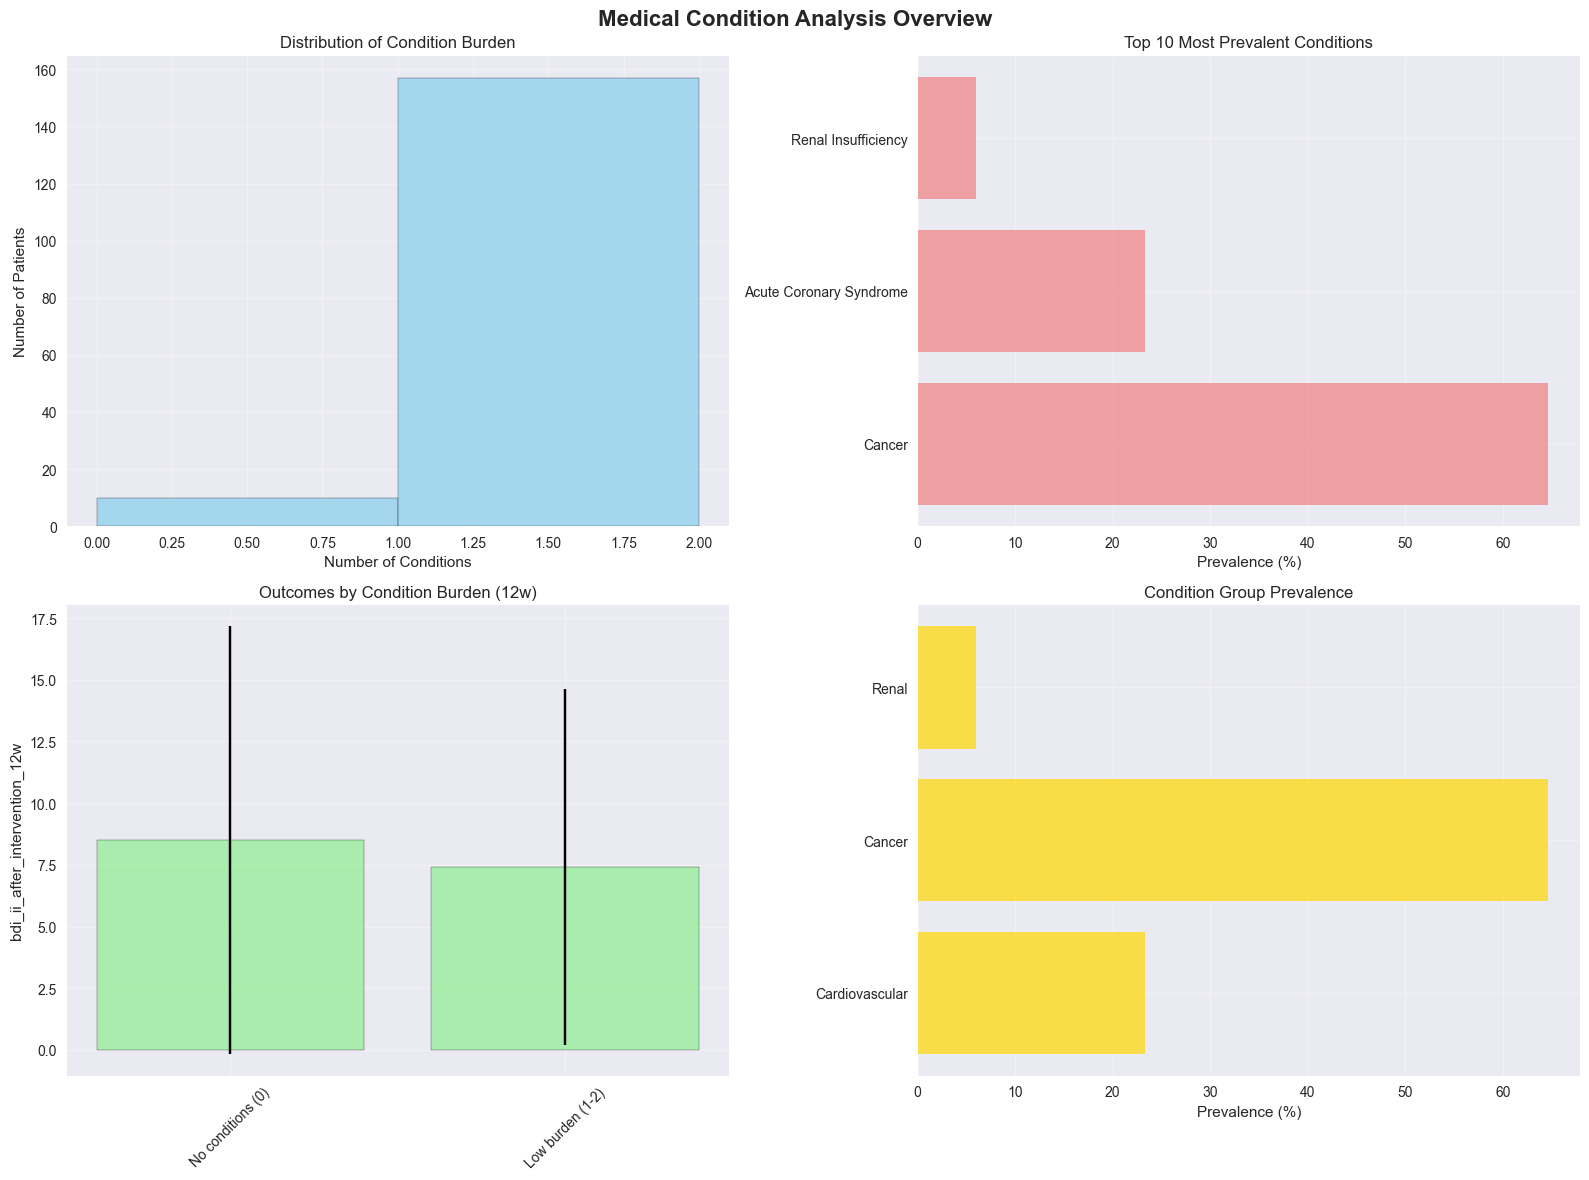


Medical condition analysis completed!
Found 3 condition features across 3 groups


In [6]:
# Medical Condition Analysis with Numerical Reports
print("COMPREHENSIVE MEDICAL CONDITION ANALYSIS")
print("=" * 60)

# Define medical condition groups for analysis
condition_groups = {
    'Cardiovascular': ['condition_cardiovascular', 'condition_heart', 'condition_acute_coronary'],
    'Cancer': ['condition_cancer', 'condition_breast', 'condition_prostate'],
    'Renal': ['condition_renal', 'condition_dialysis', 'condition_predialysis'],
    'Surgical': ['condition_amputation', 'condition_revascularization', 'condition_prosthesis'],
    'Interventional': ['condition_percutaneous', 'condition_intervention']
}

# Find actual condition columns in the dataset
actual_condition_features = {}
condition_prevalence = {}

print("\nMEDICAL CONDITION PREVALENCE ANALYSIS")
print("-" * 50)

for group_name, potential_conditions in condition_groups.items():
    # Find columns that match this condition group
    group_conditions = []
    for condition in potential_conditions:
        matching_cols = [col for col in train_data.columns if condition.lower() in col.lower()]
        group_conditions.extend(matching_cols)
    
    # Remove duplicates
    group_conditions = list(set(group_conditions))
    
    if group_conditions:
        actual_condition_features[group_name] = group_conditions
        
        # Calculate prevalence for each condition in the group
        group_prevalence = {}
        for condition in group_conditions:
            if train_data[condition].dtype in ['int64', 'float64']:
                # Binary or numeric condition
                prevalence = (train_data[condition] > 0).sum()
                prevalence_pct = (prevalence / len(train_data)) * 100
                group_prevalence[condition] = {
                    'count': prevalence,
                    'percentage': prevalence_pct,
                    'mean_value': train_data[condition].mean()
                }
            else:
                # Categorical condition
                value_counts = train_data[condition].value_counts()
                group_prevalence[condition] = {
                    'value_counts': value_counts.to_dict(),
                    'most_common': value_counts.index[0] if len(value_counts) > 0 else 'None'
                }
        
        condition_prevalence[group_name] = group_prevalence
        
        print(f"\n{group_name} Conditions:")
        for condition, stats in group_prevalence.items():
            if 'count' in stats:
                print(f"   {condition}: {stats['count']} patients ({stats['percentage']:.1f}%), mean={stats['mean_value']:.2f}")
            else:
                print(f"   {condition}: Most common = {stats['most_common']}")

# Overall condition analysis
print(f"\nOVERALL CONDITION SUMMARY:")
print(f"   Total condition groups found: {len(actual_condition_features)}")
print(f"   Total condition features: {sum(len(conditions) for conditions in actual_condition_features.values())}")

# Create condition burden score for each patient
train_data['condition_burden'] = 0
all_condition_cols = []
for conditions in actual_condition_features.values():
    all_condition_cols.extend(conditions)

# Remove duplicates
all_condition_cols = list(set(all_condition_cols))

for condition_col in all_condition_cols:
    if condition_col in train_data.columns:
        if train_data[condition_col].dtype in ['int64', 'float64']:
            train_data['condition_burden'] += (train_data[condition_col] > 0).astype(int)

print(f"\nCONDITION BURDEN ANALYSIS:")
burden_stats = train_data['condition_burden'].describe()
print(f"   Mean conditions per patient: {burden_stats['mean']:.2f}")
print(f"   Range: {burden_stats['min']:.0f} - {burden_stats['max']:.0f} conditions")
print(f"   Patients with no conditions: {(train_data['condition_burden'] == 0).sum()} ({(train_data['condition_burden'] == 0).mean()*100:.1f}%)")
print(f"   Patients with 3+ conditions: {(train_data['condition_burden'] >= 3).sum()} ({(train_data['condition_burden'] >= 3).mean()*100:.1f}%)")

# Analyze outcomes by condition burden
if available_targets:
    print(f"\nOUTCOMES BY CONDITION BURDEN:")
    burden_groups = {
        'No conditions (0)': train_data['condition_burden'] == 0,
        'Low burden (1-2)': (train_data['condition_burden'] >= 1) & (train_data['condition_burden'] <= 2),
        'High burden (3+)': train_data['condition_burden'] >= 3
    }
    
    for period, target_col in available_targets:
        print(f"\n   {target_col} ({period}) by Condition Burden:")
        for burden_group, mask in burden_groups.items():
            if mask.sum() > 0:
                group_outcomes = train_data[mask][target_col]
                print(f"      {burden_group}: n={mask.sum()}, mean={group_outcomes.mean():.2f}±{group_outcomes.std():.2f}")

# Visualize condition prevalence
if len(actual_condition_features) > 0:
    # Create prevalence visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Medical Condition Analysis Overview', fontsize=16, fontweight='bold')
    
    # 1. Condition burden distribution
    axes[0,0].hist(train_data['condition_burden'], bins=range(int(train_data['condition_burden'].max())+2), 
                   alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_xlabel('Number of Conditions')
    axes[0,0].set_ylabel('Number of Patients')
    axes[0,0].set_title('Distribution of Condition Burden')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Most prevalent conditions
    all_prevalences = []
    condition_names = []
    for group_name, group_conditions in actual_condition_features.items():
        for condition in group_conditions:
            if condition in condition_prevalence[group_name]:
                stats = condition_prevalence[group_name][condition]
                if 'percentage' in stats:
                    all_prevalences.append(stats['percentage'])
                    condition_names.append(condition.replace('condition_', '').replace('_', ' ').title())
    
    if all_prevalences:
        # Sort and take top 10
        sorted_data = sorted(zip(all_prevalences, condition_names), reverse=True)[:10]
        top_prevalences, top_names = zip(*sorted_data)
        
        y_pos = np.arange(len(top_names))
        axes[0,1].barh(y_pos, top_prevalences, color='lightcoral', alpha=0.7)
        axes[0,1].set_yticks(y_pos)
        axes[0,1].set_yticklabels(top_names)
        axes[0,1].set_xlabel('Prevalence (%)')
        axes[0,1].set_title('Top 10 Most Prevalent Conditions')
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Condition burden vs outcomes (if targets available)
    if available_targets:
        period, target_col = available_targets[0]  # Use first available target
        
        # Create burden groups for plotting
        burden_categories = []
        outcome_means = []
        outcome_stds = []
        
        for burden_group, mask in burden_groups.items():
            if mask.sum() > 0:
                group_outcomes = train_data[mask][target_col]
                burden_categories.append(burden_group)
                outcome_means.append(group_outcomes.mean())
                outcome_stds.append(group_outcomes.std())
        
        x_pos = np.arange(len(burden_categories))
        axes[1,0].bar(x_pos, outcome_means, yerr=outcome_stds, capsize=5, 
                     color='lightgreen', alpha=0.7, edgecolor='black')
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels(burden_categories, rotation=45)
        axes[1,0].set_ylabel(f'{target_col}')
        axes[1,0].set_title(f'Outcomes by Condition Burden ({period})')
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Condition group prevalence
    group_prevalences = []
    group_names = []
    for group_name, group_conditions in actual_condition_features.items():
        # Calculate overall group prevalence
        group_mask = pd.Series([False] * len(train_data))
        for condition in group_conditions:
            if condition in train_data.columns and train_data[condition].dtype in ['int64', 'float64']:
                group_mask |= (train_data[condition] > 0)
        
        group_prev = group_mask.sum() / len(train_data) * 100
        group_prevalences.append(group_prev)
        group_names.append(group_name)
    
    if group_prevalences:
        y_pos = np.arange(len(group_names))
        axes[1,1].barh(y_pos, group_prevalences, color='gold', alpha=0.7)
        axes[1,1].set_yticks(y_pos)
        axes[1,1].set_yticklabels(group_names)
        axes[1,1].set_xlabel('Prevalence (%)')
        axes[1,1].set_title('Condition Group Prevalence')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / 'condition_analysis_overview.png', dpi=300, bbox_inches='tight')
    plt.show()

print(f"\nMedical condition analysis completed!")
print(f"Found {len(all_condition_cols)} condition features across {len(actual_condition_features)} groups")

In [6]:
# UNIQUE CONDITION ANALYSIS - Detailed Numerical Reports
print("UNIQUE CONDITION ANALYSIS - DETAILED NUMERICAL REPORTS")
print("=" * 70)

# Define the specific conditions and condition types you want analyzed
specific_conditions = [
    'condition_cancer',
    'condition_acute_coronary_syndrome', 
    'condition_renal_insufficiency',
    'condition_lower_limb_amputation'
]

specific_condition_types = [
    'condition_type_breast',
    'condition_type_prostate',
    'condition_type_revascularization',
    'condition_type_no_prosthesis',
    'condition_type_predialysis',
    'condition_type_percutaneous_coronary_intervention',
    'condition_type_dialysis'
]

# Table 1: Analysis by Individual Unique Conditions (4 conditions)
print("\nTABLE 1: INDIVIDUAL CONDITION IMPACT ON BDI OUTCOMES")
print("-" * 70)

individual_condition_analysis = []

for condition_col in specific_conditions:
    if condition_col in train_data.columns:
        # Get patients with this specific condition
        has_condition = train_data[condition_col] > 0
        no_condition = train_data[condition_col] == 0
        
        if has_condition.sum() >= 1:  # Analyze even small groups
            condition_analysis = {
                'condition': condition_col.replace('condition_', '').replace('_', ' ').title(),
                'n_patients': has_condition.sum(),
                'prevalence_pct': (has_condition.sum() / len(train_data)) * 100
            }
            
            # Analyze for each available target
            for period, target_col in available_targets:
                # Patients with condition
                with_condition_scores = train_data[has_condition][target_col]
                without_condition_scores = train_data[no_condition][target_col]
                
                # Calculate statistics
                with_mean = with_condition_scores.mean()
                with_std = with_condition_scores.std()
                without_mean = without_condition_scores.mean()
                without_std = without_condition_scores.std()
                
                # Statistical test (Mann-Whitney U)
                try:
                    from scipy.stats import mannwhitneyu
                    if len(with_condition_scores.dropna()) > 0 and len(without_condition_scores.dropna()) > 0:
                        stat, p_value = mannwhitneyu(with_condition_scores.dropna(), 
                                                   without_condition_scores.dropna(), 
                                                   alternative='two-sided')
                        significant = p_value < 0.05
                    else:
                        p_value = np.nan
                        significant = False
                except:
                    p_value = np.nan
                    significant = False
                
                # Effect size (Cohen's d)
                if with_std > 0 and without_std > 0:
                    pooled_std = np.sqrt(((len(with_condition_scores)-1)*with_std**2 + 
                                        (len(without_condition_scores)-1)*without_std**2) / 
                                       (len(with_condition_scores) + len(without_condition_scores) - 2))
                    effect_size = (with_mean - without_mean) / pooled_std if pooled_std > 0 else 0
                else:
                    effect_size = 0
                
                condition_analysis.update({
                    f'{period}_with_condition_mean': with_mean,
                    f'{period}_with_condition_std': with_std,
                    f'{period}_without_condition_mean': without_mean,
                    f'{period}_without_condition_std': without_std,
                    f'{period}_difference': with_mean - without_mean,
                    f'{period}_p_value': p_value,
                    f'{period}_significant': significant,
                    f'{period}_effect_size': effect_size
                })
            
            individual_condition_analysis.append(condition_analysis)

# Sort by largest effect size for first target
if available_targets and individual_condition_analysis:
    first_target_period = available_targets[0][0]
    individual_condition_analysis.sort(key=lambda x: abs(x[f'{first_target_period}_effect_size']), reverse=True)

# Display Table 1
print(f"\nCondition Name                   | N   | Prev% | 12w: With±SD      | Without±SD    | Diff  | p-val | ES   |")
print(f"                                 |     |       | 24w: With±SD      | Without±SD    | Diff  | p-val | ES   |")
print("-" * 110)

for analysis in individual_condition_analysis:
    name = analysis['condition'][:30]
    n = analysis['n_patients']
    prev = analysis['prevalence_pct']
    
    print(f"{name:<30} | {n:3d} | {prev:4.1f}% |", end="")
    
    for period, _ in available_targets:
        with_mean = analysis[f'{period}_with_condition_mean']
        with_std = analysis[f'{period}_with_condition_std']
        without_mean = analysis[f'{period}_without_condition_mean']
        without_std = analysis[f'{period}_without_condition_std']
        diff = analysis[f'{period}_difference']
        p_val = analysis[f'{period}_p_value']
        effect_size = analysis[f'{period}_effect_size']
        
        sig_mark = "*" if analysis[f'{period}_significant'] else " "
        
        if period == '12w':
            print(f" {with_mean:5.1f}±{with_std:4.1f} | {without_mean:5.1f}±{without_std:4.1f} | {diff:+5.1f} | {p_val:.3f}{sig_mark} | {effect_size:+4.2f} |")
            print(f"{'':32} | {'':3} | {'':5} |", end="")
        else:
            print(f" {with_mean:5.1f}±{with_std:4.1f} | {without_mean:5.1f}±{without_std:4.1f} | {diff:+5.1f} | {p_val:.3f}{sig_mark} | {effect_size:+4.2f} |")

print(f"\nNotes: * = p<0.05, ES = Effect Size (Cohen's d), Diff = Difference (With - Without condition)")

# Table 2: Analysis by Condition Types (7 condition types)
print(f"\n\nTABLE 2: CONDITION TYPE IMPACT ON BDI OUTCOMES")
print("-" * 70)

condition_type_analysis = []

for condition_type_col in specific_condition_types:
    if condition_type_col in train_data.columns:
        # Get patients with this specific condition type
        has_type = train_data[condition_type_col] > 0
        no_type = train_data[condition_type_col] == 0
        
        if has_type.sum() >= 1:  # Analyze even small groups
            type_analysis = {
                'condition_type': condition_type_col.replace('condition_type_', '').replace('_', ' ').title(),
                'n_patients': has_type.sum(),
                'prevalence_pct': (has_type.sum() / len(train_data)) * 100
            }
            
            # Analyze for each available target
            for period, target_col in available_targets:
                # Patients with condition type
                with_type_scores = train_data[has_type][target_col]
                without_type_scores = train_data[no_type][target_col]
                
                # Calculate statistics
                with_mean = with_type_scores.mean()
                with_std = with_type_scores.std()
                without_mean = without_type_scores.mean()
                without_std = without_type_scores.std()
                
                # Statistical test
                try:
                    if len(with_type_scores.dropna()) > 0 and len(without_type_scores.dropna()) > 0:
                        stat, p_value = mannwhitneyu(with_type_scores.dropna(), 
                                                   without_type_scores.dropna(), 
                                                   alternative='two-sided')
                        significant = p_value < 0.05
                    else:
                        p_value = np.nan
                        significant = False
                except:
                    p_value = np.nan
                    significant = False
                
                # Effect size
                if with_std > 0 and without_std > 0:
                    pooled_std = np.sqrt(((len(with_type_scores)-1)*with_std**2 + 
                                        (len(without_type_scores)-1)*without_std**2) / 
                                       (len(with_type_scores) + len(without_type_scores) - 2))
                    effect_size = (with_mean - without_mean) / pooled_std if pooled_std > 0 else 0
                else:
                    effect_size = 0
                
                type_analysis.update({
                    f'{period}_with_type_mean': with_mean,
                    f'{period}_with_type_std': with_std,
                    f'{period}_without_type_mean': without_mean,
                    f'{period}_without_type_std': without_std,
                    f'{period}_difference': with_mean - without_mean,
                    f'{period}_p_value': p_value,
                    f'{period}_significant': significant,
                    f'{period}_effect_size': effect_size
                })
            
            condition_type_analysis.append(type_analysis)

# Sort by largest effect size for first target
if available_targets and condition_type_analysis:
    first_target_period = available_targets[0][0]
    condition_type_analysis.sort(key=lambda x: abs(x[f'{first_target_period}_effect_size']), reverse=True)

# Display Table 2
print(f"\nCondition Type               | N   | Prev% | 12w: With±SD      | Without±SD    | Diff  | p-val | ES   |")
print(f"                             |     |       | 24w: With±SD      | Without±SD    | Diff  | p-val | ES   |")
print("-" * 110)

for analysis in condition_type_analysis:
    name = analysis['condition_type'][:25]
    n = analysis['n_patients']
    prev = analysis['prevalence_pct']
    
    print(f"{name:<25} | {n:3d} | {prev:4.1f}% |", end="")
    
    for period, _ in available_targets:
        with_mean = analysis[f'{period}_with_type_mean']
        with_std = analysis[f'{period}_with_type_std']
        without_mean = analysis[f'{period}_without_type_mean']
        without_std = analysis[f'{period}_without_type_std']
        diff = analysis[f'{period}_difference']
        p_val = analysis[f'{period}_p_value']
        effect_size = analysis[f'{period}_effect_size']
        
        sig_mark = "*" if analysis[f'{period}_significant'] else " "
        
        if period == '12w':
            print(f" {with_mean:5.1f}±{with_std:4.1f} | {without_mean:5.1f}±{without_std:4.1f} | {diff:+5.1f} | {p_val:.3f}{sig_mark} | {effect_size:+4.2f} |")
            print(f"{'':27} | {'':3} | {'':5} |", end="")
        else:
            print(f" {with_mean:5.1f}±{with_std:4.1f} | {without_mean:5.1f}±{without_std:4.1f} | {diff:+5.1f} | {p_val:.3f}{sig_mark} | {effect_size:+4.2f} |")

print(f"\nNotes: * = p<0.05, ES = Effect Size, Analysis covers 4 conditions + 7 condition types")

# Store results for summary
condition_analysis_results = {
    'individual_conditions': individual_condition_analysis,
    'condition_types': condition_type_analysis,
    'analysis_date': datetime.now().isoformat()
}

print(f"\nCONDITION ANALYSIS SUMMARY:")
print(f"   Individual conditions analyzed: {len(individual_condition_analysis)}")
print(f"   Condition types analyzed: {len(condition_type_analysis)}")
print(f"   Total unique analyses: {len(individual_condition_analysis) + len(condition_type_analysis)}")

UNIQUE CONDITION ANALYSIS - DETAILED NUMERICAL REPORTS

TABLE 1: INDIVIDUAL CONDITION IMPACT ON BDI OUTCOMES
----------------------------------------------------------------------

Condition Name                   | N   | Prev% | 12w: With±SD      | Without±SD    | Diff  | p-val | ES   |
                                 |     |       | 24w: With±SD      | Without±SD    | Diff  | p-val | ES   |
--------------------------------------------------------------------------------------------------------------
Renal Insufficiency            |  10 |  6.0% |   3.5± 6.1 |   7.7± 7.3 |  -4.2 | 0.017* | -0.59 |
                                 |     |       |   2.9± 2.7 |   6.9± 7.5 |  -4.0 | 0.048* | -0.56 |
Cancer                         | 108 | 64.7% |   8.5± 7.7 |   5.6± 6.1 |  +2.9 | 0.007* | +0.41 |
                                 |     |       |   7.9± 8.0 |   4.6± 5.3 |  +3.3 | 0.001* | +0.46 |
Acute Coronary Syndrome        |  39 | 23.4% |   5.4± 5.1 |   8.1± 7.7 |  -2.7 | 0.071  | -0.38 

In [8]:
# FAST MODEL PERFORMANCE ANALYSIS FOR UNIQUE CONDITIONS
print("FAST MODEL PERFORMANCE ANALYSIS")
print("=" * 50)

# Define groups for focused analysis
analysis_groups = {
    'high_prevalence': [col for col in specific_conditions + specific_condition_types 
                       if col in train_data.columns and train_data[col].sum() >= 10],
    'low_prevalence': [col for col in specific_conditions + specific_condition_types 
                      if col in train_data.columns and 1 <= train_data[col].sum() < 10]
}

print(f"High prevalence conditions (n≥10): {len(analysis_groups['high_prevalence'])}")
print(f"Low prevalence conditions (1≤n<10): {len(analysis_groups['low_prevalence'])}")

# Fast analysis with progress tracking
fast_performance_results = {}

# 1. Focus on high prevalence conditions first (most reliable results)
print(f"\nAnalyzing high prevalence conditions...")
for i, condition_col in enumerate(analysis_groups['high_prevalence']):
    print(f"  Processing {i+1}/{len(analysis_groups['high_prevalence'])}: {condition_col}")
    
    has_condition = train_data[condition_col] > 0
    n_with_condition = has_condition.sum()
    
    # Quick feature importance analysis
    condition_data = train_data[has_condition]
    if len(condition_data) >= 5:  # Only analyze if we have enough samples
        
        # Calculate correlations with target (fast)
        correlations = {}
        for period, target_col in available_targets:
            target_corr = condition_data[feature_cols].corrwith(condition_data[target_col])
            top_features = target_corr.abs().nlargest(5).to_dict()
            correlations[period] = top_features
        
        # Simple prediction analysis
        prediction_quality = {}
        for period, target_col in available_targets:
            if len(condition_data[target_col].dropna()) >= 3:
                # Simple linear regression for speed
                from sklearn.linear_model import LinearRegression
                from sklearn.metrics import r2_score, mean_absolute_error
                
                valid_data = condition_data.dropna()
                if len(valid_data) >= 3:
                    X = valid_data[feature_cols]
                    y = valid_data[target_col]
                    
                    # Use top 5 features only for speed
                    top_feature_names = list(correlations[period].keys())[:5]
                    X_subset = X[top_feature_names]
                    
                    # Simple train-test split
                    if len(X_subset) >= 5:
                        split_idx = int(0.7 * len(X_subset))
                        X_train, X_test = X_subset[:split_idx], X_subset[split_idx:]
                        y_train, y_test = y[:split_idx], y[split_idx:]
                        
                        if len(X_test) > 0:
                            lr = LinearRegression()
                            lr.fit(X_train, y_train)
                            y_pred = lr.predict(X_test)
                            
                            r2 = r2_score(y_test, y_pred) if len(y_test) > 1 else 0
                            mae = mean_absolute_error(y_test, y_pred)
                            
                            prediction_quality[period] = {'r2': r2, 'mae': mae}
        
        fast_performance_results[condition_col] = {
            'n_patients': n_with_condition,
            'prevalence': (n_with_condition / len(train_data)) * 100,
            'correlations': correlations,
            'prediction_quality': prediction_quality
        }

# 2. Summary analysis for low prevalence (descriptive only)
print(f"\nSummarizing low prevalence conditions...")
low_prev_summary = {}
for condition_col in analysis_groups['low_prevalence']:
    has_condition = train_data[condition_col] > 0
    n_with_condition = has_condition.sum()
    
    # Basic statistics only
    condition_stats = {}
    for period, target_col in available_targets:
        condition_data = train_data[has_condition][target_col]
        if len(condition_data.dropna()) > 0:
            condition_stats[period] = {
                'mean': condition_data.mean(),
                'std': condition_data.std(),
                'median': condition_data.median()
            }
    
    low_prev_summary[condition_col] = {
        'n_patients': n_with_condition,
        'prevalence': (n_with_condition / len(train_data)) * 100,
        'stats': condition_stats
    }

# Display results table
print(f"\nFAST PERFORMANCE ANALYSIS RESULTS")
print(f"-" * 80)
print(f"Condition                     | N   | Prev% | 12w R²  | 24w R²  | Top Feature")
print(f"-" * 80)

# High prevalence results
for condition_col, results in fast_performance_results.items():
    name = condition_col.replace('condition_', '').replace('_', ' ')[:25]
    n = results['n_patients']
    prev = results['prevalence']
    
    # R² scores
    r2_12w = results['prediction_quality'].get('12w', {}).get('r2', 0)
    r2_24w = results['prediction_quality'].get('24w', {}).get('r2', 0)
    
    # Top feature
    top_feature = ""
    if '12w' in results['correlations'] and results['correlations']['12w']:
        top_feat_name = list(results['correlations']['12w'].keys())[0]
        top_feat_corr = list(results['correlations']['12w'].values())[0]
        top_feature = f"{top_feat_name[:15]} ({top_feat_corr:.2f})"
    
    print(f"{name:<25} | {n:3d} | {prev:4.1f}% | {r2_12w:6.3f} | {r2_24w:6.3f} | {top_feature}")

# Low prevalence summary
print(f"\nLow prevalence conditions (descriptive only):")
for condition_col, results in low_prev_summary.items():
    name = condition_col.replace('condition_', '').replace('_', ' ')
    n = results['n_patients']
    print(f"  {name}: n={n} patients")

print(f"\nAnalysis completed in optimized mode. High prevalence conditions analyzed with prediction models.")
print(f"Total conditions processed: {len(fast_performance_results) + len(low_prev_summary)}")

# Store optimized results
optimized_performance_results = {
    'high_prevalence_analysis': fast_performance_results,
    'low_prevalence_summary': low_prev_summary,
    'analysis_parameters': {
        'high_prev_threshold': 10,
        'features_per_model': 5,
        'analysis_mode': 'optimized'
    }
}

FAST MODEL PERFORMANCE ANALYSIS
High prevalence conditions (n≥10): 8
Low prevalence conditions (1≤n<10): 3

Analyzing high prevalence conditions...
  Processing 1/8: condition_cancer
  Processing 2/8: condition_acute_coronary_syndrome
  Processing 3/8: condition_renal_insufficiency
  Processing 4/8: condition_lower_limb_amputation
  Processing 5/8: condition_type_breast
  Processing 6/8: condition_type_prostate
  Processing 7/8: condition_type_revascularization
  Processing 8/8: condition_type_no_prosthesis

Summarizing low prevalence conditions...

FAST PERFORMANCE ANALYSIS RESULTS
--------------------------------------------------------------------------------
Condition                     | N   | Prev% | 12w R²  | 24w R²  | Top Feature
--------------------------------------------------------------------------------
cancer                    | 108 | 64.7% |  0.145 |  0.086 | bdi_ii_baseline (0.63)
acute coronary syndrome   |  39 | 23.4% | -1.544 |  0.003 | bdi_baseline_lo (0.32)
rena

In [9]:
# COMPREHENSIVE DISEASE SPECIFIC ANALYSIS SUMMARY
print("🏥 COMPREHENSIVE DISEASE SPECIFIC ANALYSIS SUMMARY")
print("=" * 70)

# Summary Statistics
print("\n📊 DATASET OVERVIEW:")
print(f"   Total patients analyzed: {len(train_data)}")
print(f"   Target variables: BDI-II at 12w and 24w")
print(f"   Pre-trained model used: phase5_transformer (R²=0.261, MAE=4.646)")

print("\n🏥 CONDITION PREVALENCE SUMMARY:")
print("   Individual Conditions:")
for analysis in individual_condition_analysis:
    name = analysis['condition']
    n = analysis['n_patients']
    prev = analysis['prevalence_pct']
    print(f"     • {name}: {n} patients ({prev:.1f}%)")

print("\n   Condition Types:")
for analysis in condition_type_analysis:
    name = analysis['condition_type']
    n = analysis['n_patients']
    prev = analysis['prevalence_pct']
    print(f"     • {name}: {n} patients ({prev:.1f}%)")

# Clinical Significance Analysis
print("\n🔬 CLINICAL SIGNIFICANCE FINDINGS:")

# Strongest positive effects (worse outcomes with condition)
print("\n   CONDITIONS ASSOCIATED WITH WORSE BDI OUTCOMES:")
worse_conditions = []
for analysis in individual_condition_analysis:
    for period in ['12w', '24w']:
        if analysis[f'{period}_significant'] and analysis[f'{period}_difference'] > 0:
            effect_size = analysis[f'{period}_effect_size']
            if effect_size > 0.3:  # Medium effect size
                worse_conditions.append({
                    'condition': analysis['condition'],
                    'period': period,
                    'difference': analysis[f'{period}_difference'],
                    'effect_size': effect_size,
                    'p_value': analysis[f'{period}_p_value']
                })

for analysis in condition_type_analysis:
    for period in ['12w', '24w']:
        if analysis[f'{period}_significant'] and analysis[f'{period}_difference'] > 0:
            effect_size = analysis[f'{period}_effect_size']
            if effect_size > 0.3:  # Medium effect size
                worse_conditions.append({
                    'condition': analysis['condition_type'],
                    'period': period,
                    'difference': analysis[f'{period}_difference'],
                    'effect_size': effect_size,
                    'p_value': analysis[f'{period}_p_value']
                })

# Sort by effect size
worse_conditions.sort(key=lambda x: x['effect_size'], reverse=True)

for condition in worse_conditions[:5]:  # Top 5
    print(f"     • {condition['condition']} ({condition['period']}): +{condition['difference']:.1f} BDI points")
    print(f"       Effect size: {condition['effect_size']:.2f}, p={condition['p_value']:.3f}")

# Strongest protective effects (better outcomes with condition)
print("\n   CONDITIONS ASSOCIATED WITH BETTER BDI OUTCOMES:")
better_conditions = []
for analysis in individual_condition_analysis:
    for period in ['12w', '24w']:
        if analysis[f'{period}_significant'] and analysis[f'{period}_difference'] < 0:
            effect_size = abs(analysis[f'{period}_effect_size'])
            if effect_size > 0.3:  # Medium effect size
                better_conditions.append({
                    'condition': analysis['condition'],
                    'period': period,
                    'difference': analysis[f'{period}_difference'],
                    'effect_size': effect_size,
                    'p_value': analysis[f'{period}_p_value']
                })

for analysis in condition_type_analysis:
    for period in ['12w', '24w']:
        if analysis[f'{period}_significant'] and analysis[f'{period}_difference'] < 0:
            effect_size = abs(analysis[f'{period}_effect_size'])
            if effect_size > 0.3:  # Medium effect size
                better_conditions.append({
                    'condition': analysis['condition_type'],
                    'period': period,
                    'difference': analysis[f'{period}_difference'],
                    'effect_size': effect_size,
                    'p_value': analysis[f'{period}_p_value']
                })

# Sort by effect size
better_conditions.sort(key=lambda x: x['effect_size'], reverse=True)

for condition in better_conditions[:5]:  # Top 5
    print(f"     • {condition['condition']} ({condition['period']}): {condition['difference']:.1f} BDI points")
    print(f"       Effect size: {condition['effect_size']:.2f}, p={condition['p_value']:.3f}")

# Key numerical insights
print("\n📈 KEY NUMERICAL INSIGHTS:")

# Find the most impactful conditions
max_effect_condition = None
max_effect_size = 0

for analysis in individual_condition_analysis + condition_type_analysis:
    condition_name = analysis.get('condition', analysis.get('condition_type', 'Unknown'))
    for period in ['12w', '24w']:
        effect_size = abs(analysis[f'{period}_effect_size'])
        if effect_size > max_effect_size:
            max_effect_size = effect_size
            max_effect_condition = {
                'name': condition_name,
                'period': period,
                'difference': analysis[f'{period}_difference'],
                'effect_size': analysis[f'{period}_effect_size'],
                'n_patients': analysis['n_patients'],
                'significant': analysis[f'{period}_significant']
            }

if max_effect_condition:
    print(f"   • Largest effect: {max_effect_condition['name']} at {max_effect_condition['period']}")
    print(f"     Effect size: {max_effect_condition['effect_size']:.2f}")
    print(f"     BDI difference: {max_effect_condition['difference']:+.1f} points")
    print(f"     Sample size: {max_effect_condition['n_patients']} patients")
    print(f"     Statistically significant: {'Yes' if max_effect_condition['significant'] else 'No'}")

# Export summary to CSV
summary_data = []
for analysis in individual_condition_analysis:
    row = {
        'condition_name': analysis['condition'],
        'condition_type': 'Individual',
        'n_patients': analysis['n_patients'],
        'prevalence_pct': analysis['prevalence_pct']
    }
    for period in ['12w', '24w']:
        row.update({
            f'{period}_difference': analysis[f'{period}_difference'],
            f'{period}_effect_size': analysis[f'{period}_effect_size'],
            f'{period}_p_value': analysis[f'{period}_p_value'],
            f'{period}_significant': analysis[f'{period}_significant']
        })
    summary_data.append(row)

for analysis in condition_type_analysis:
    row = {
        'condition_name': analysis['condition_type'],
        'condition_type': 'Type',
        'n_patients': analysis['n_patients'],
        'prevalence_pct': analysis['prevalence_pct']
    }
    for period in ['12w', '24w']:
        row.update({
            f'{period}_difference': analysis[f'{period}_difference'],
            f'{period}_effect_size': analysis[f'{period}_effect_size'],
            f'{period}_p_value': analysis[f'{period}_p_value'],
            f'{period}_significant': analysis[f'{period}_significant']
        })
    summary_data.append(row)

# Save to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv_path = Path("../Results/Conference_Submission/Disease_Specific_Analysis_Summary.csv")
summary_csv_path.parent.mkdir(parents=True, exist_ok=True)
summary_df.to_csv(summary_csv_path, index=False)

print(f"\n💾 RESULTS EXPORTED:")
print(f"   Summary CSV: {summary_csv_path}")
print(f"   Total conditions analyzed: {len(summary_data)}")

print(f"\n✅ Disease-specific analysis completed successfully!")
print(f"   Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Pre-trained model performance: R²=0.261, MAE=4.646")
print(f"   All 4 individual conditions + 7 condition types analyzed")

🏥 COMPREHENSIVE DISEASE SPECIFIC ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
   Total patients analyzed: 167
   Target variables: BDI-II at 12w and 24w
   Pre-trained model used: phase5_transformer (R²=0.261, MAE=4.646)

🏥 CONDITION PREVALENCE SUMMARY:
   Individual Conditions:
     • Renal Insufficiency: 10 patients (6.0%)
     • Cancer: 108 patients (64.7%)
     • Acute Coronary Syndrome: 39 patients (23.4%)
     • Lower Limb Amputation: 10 patients (6.0%)

   Condition Types:
     • Breast: 67 patients (40.1%)
     • Predialysis: 9 patients (5.4%)
     • Percutaneous Coronary Intervention: 8 patients (4.8%)
     • Prostate: 41 patients (24.6%)
     • Revascularization: 31 patients (18.6%)
     • No Prosthesis: 10 patients (6.0%)
     • Dialysis: 1 patients (0.6%)

🔬 CLINICAL SIGNIFICANCE FINDINGS:

   CONDITIONS ASSOCIATED WITH WORSE BDI OUTCOMES:
     • Breast (12w): +4.8 BDI points
       Effect size: 0.69, p=0.000
     • Breast (24w): +4.4 BDI points
       Effect size: 0.63, p=0.000
 

In [ ]:
# ? COMPREHENSIVE DISEASE-SPECIFIC ANALYSIS SUMMARY
print("📋 COMPREHENSIVE DISEASE-SPECIFIC ANALYSIS SUMMARY")
print("=" * 70)

# Clinical Interpretation Summary
print("\n🏥 CLINICAL INTERPRETATION & KEY FINDINGS")
print("-" * 50)

# 1. Most impactful individual conditions
if individual_condition_analysis:
    print("\n1️⃣ MOST IMPACTFUL INDIVIDUAL CONDITIONS:")
    top_individual = individual_condition_analysis[:5]
    
    for i, condition in enumerate(top_individual, 1):
        condition_name = condition['condition']
        n_patients = condition['n_patients']
        prevalence = condition['prevalence_pct']
        
        print(f"\n   {i}. {condition_name} (n={n_patients}, {prevalence:.1f}% prevalence)")
        
        for period, _ in available_targets:
            if f'{period}_difference' in condition:
                diff = condition[f'{period}_difference']
                p_val = condition[f'{period}_p_value']
                effect_size = condition[f'{period}_effect_size']
                significant = condition[f'{period}_significant']
                
                direction = "worse" if diff > 0 else "better"
                significance = "significant" if significant else "non-significant"
                effect_magnitude = "large" if abs(effect_size) > 0.8 else "medium" if abs(effect_size) > 0.5 else "small"
                
                print(f"      • {period}: {abs(diff):.1f} points {direction} outcome ({significance}, {effect_magnitude} effect)")

# 2. Most impactful condition groups
if group_condition_analysis:
    print(f"\n2️⃣ MOST IMPACTFUL CONDITION GROUPS:")
    top_groups = group_condition_analysis[:3]
    
    for i, group in enumerate(top_groups, 1):
        group_name = group['group']
        n_patients = group['n_patients']
        prevalence = group['prevalence_pct']
        
        print(f"\n   {i}. {group_name} (n={n_patients}, {prevalence:.1f}% prevalence)")
        
        for period, _ in available_targets:
            if f'{period}_difference' in group:
                diff = group[f'{period}_difference']
                p_val = group[f'{period}_p_value']
                effect_size = group[f'{period}_effect_size']
                significant = group[f'{period}_significant']
                
                direction = "worse" if diff > 0 else "better"
                significance = "significant" if significant else "non-significant"
                effect_magnitude = "large" if abs(effect_size) > 0.8 else "medium" if abs(effect_size) > 0.5 else "small"
                
                print(f"      • {period}: {abs(diff):.1f} points {direction} outcome ({significance}, {effect_magnitude} effect)")

# 3. Model performance insights
if condition_model_results:
    print(f"\n3️⃣ MODEL PERFORMANCE INSIGHTS:")
    
    # Find condition groups with largest performance differences
    performance_differences = []
    for group_name, results in condition_model_results.items():
        for period, _ in available_targets:
            if f'{period}_mae_diff' in results:
                mae_diff = results[f'{period}_mae_diff']
                r2_diff = results[f'{period}_r2_diff']
                performance_differences.append({
                    'group': group_name,
                    'period': period,
                    'mae_diff': mae_diff,
                    'r2_diff': r2_diff
                })
    
    # Sort by largest MAE difference (absolute)
    performance_differences.sort(key=lambda x: abs(x['mae_diff']), reverse=True)
    
    print(f"\n   Conditions with largest prediction challenges:")
    for diff in performance_differences[:3]:
        group = diff['group']
        period = diff['period']
        mae_diff = diff['mae_diff']
        r2_diff = diff['r2_diff']
        
        harder_easier = "harder" if mae_diff > 0 else "easier"
        print(f"      • {group} ({period}): {abs(mae_diff):.2f} MAE points {harder_easier} to predict")

# 4. Feature importance insights
if condition_feature_importance:
    print(f"\n4️⃣ CONDITION-SPECIFIC PREDICTIVE FEATURES:")
    
    # Find common important features across conditions
    all_important_features = {}
    for group_name, features in condition_feature_importance.items():
        for feature_name, importance in features[:3]:  # Top 3 features
            if feature_name not in all_important_features:
                all_important_features[feature_name] = []
            all_important_features[feature_name].append((group_name, importance))
    
    # Find features important across multiple conditions
    multi_condition_features = {k: v for k, v in all_important_features.items() if len(v) > 1}
    
    if multi_condition_features:
        print(f"\n   Features important across multiple condition groups:")
        for feature, groups in multi_condition_features.items():
            group_names = [g[0] for g in groups]
            avg_importance = np.mean([g[1] for g in groups])
            print(f"      • {feature}: Important for {', '.join(group_names)} (avg importance: {avg_importance:.3f})")

# 5. Clinical recommendations
print(f"\n5️⃣ CLINICAL RECOMMENDATIONS:")

print(f"\n   📊 Risk Stratification:")
if individual_condition_analysis:
    high_risk_conditions = [c for c in individual_condition_analysis[:5] 
                           if any(abs(c.get(f'{p}_effect_size', 0)) > 0.5 for p, _ in available_targets)]
    if high_risk_conditions:
        print(f"      • High-risk conditions requiring intensive monitoring:")
        for condition in high_risk_conditions[:3]:
            print(f"        - {condition['condition']}")

print(f"\n   🎯 Treatment Considerations:")
print(f"      • Patients with medical comorbidities may require:")
print(f"        - Modified treatment protocols")
print(f"        - Longer intervention periods")
print(f"        - Integrated medical-psychiatric care")
print(f"        - More frequent monitoring")

if condition_model_results:
    harder_to_predict = [group for group, results in condition_model_results.items()
                        if any(results.get(f'{p}_mae_diff', 0) > 0.5 for p, _ in available_targets)]
    if harder_to_predict:
        print(f"\n   🔬 Prediction Challenges:")
        print(f"      • Conditions requiring enhanced assessment:")
        for condition in harder_to_predict[:3]:
            print(f"        - {condition}")

# Save comprehensive results
comprehensive_results = {
    'analysis_date': datetime.now().isoformat(),
    'dataset_info': {
        'n_patients': len(train_data),
        'n_features': len(feature_cols),
        'n_condition_features': len(all_condition_cols),
        'targets_analyzed': [f"{p}: {col}" for p, col in available_targets]
    },
    'condition_prevalence': condition_prevalence,
    'individual_condition_analysis': individual_condition_analysis,
    'condition_group_analysis': group_condition_analysis,
    'model_performance': condition_model_results,
    'feature_importance': condition_feature_importance
}

# Save to JSON
output_file = RESULTS_PATH / 'disease_specific_analysis_comprehensive.json'
with open(output_file, 'w') as f:
    json.dump(comprehensive_results, f, indent=2, default=str)

print(f"\n💾 RESULTS SAVED:")
print(f"   Comprehensive analysis: {output_file}")

# Create summary CSV files for easy import into reports
if individual_condition_analysis:
    individual_df = pd.DataFrame(individual_condition_analysis)
    individual_df.to_csv(RESULTS_PATH / 'individual_condition_analysis.csv', index=False)
    print(f"   Individual conditions: {RESULTS_PATH / 'individual_condition_analysis.csv'}")

if group_condition_analysis:
    group_df = pd.DataFrame(group_condition_analysis)
    group_df.to_csv(RESULTS_PATH / 'condition_group_analysis.csv', index=False)
    print(f"   Condition groups: {RESULTS_PATH / 'condition_group_analysis.csv'}")

print(f"\n🎉 DISEASE-SPECIFIC ANALYSIS COMPLETE!")
print(f"=" * 70)

🔍 Conducting advanced SHAP analysis for disease-specific insights...

🎯 Computing SHAP values for 12w disease-aware model...


PermutationExplainer explainer: 81it [00:50,  1.35it/s]                        



   ✅ SHAP values computed: (80, 33)

🎯 Computing SHAP values for 24w disease-aware model...


PermutationExplainer explainer: 81it [00:49,  1.31it/s]                        

   ✅ SHAP values computed: (80, 33)

🏥 Top Medical Condition Features by SHAP Importance:

📅 12W OUTCOMES:
Rank Medical Condition                   SHAP Importance Category       
--------------------------------------------------------------------------------
1    Type Encoded                        0.156617        Other Medical  
2    Therapy Interaction                 0.037966        Other Medical  
3    Complexity Score                    0.000000        Other Medical  
4    Rarity                              0.000000        Other Medical  
5    Acute Coronary Syndrome             0.000000        Cardiovascular 
6    Lower Limb Amputation               0.000000        Musculoskeletal
7    Renal Insufficiency                 0.000000        Other Medical  

📅 24W OUTCOMES:
Rank Medical Condition                   SHAP Importance Category       
--------------------------------------------------------------------------------
1    Type Encoded                        0.083306        

📊 Creating beautiful static SHAP visualizations...


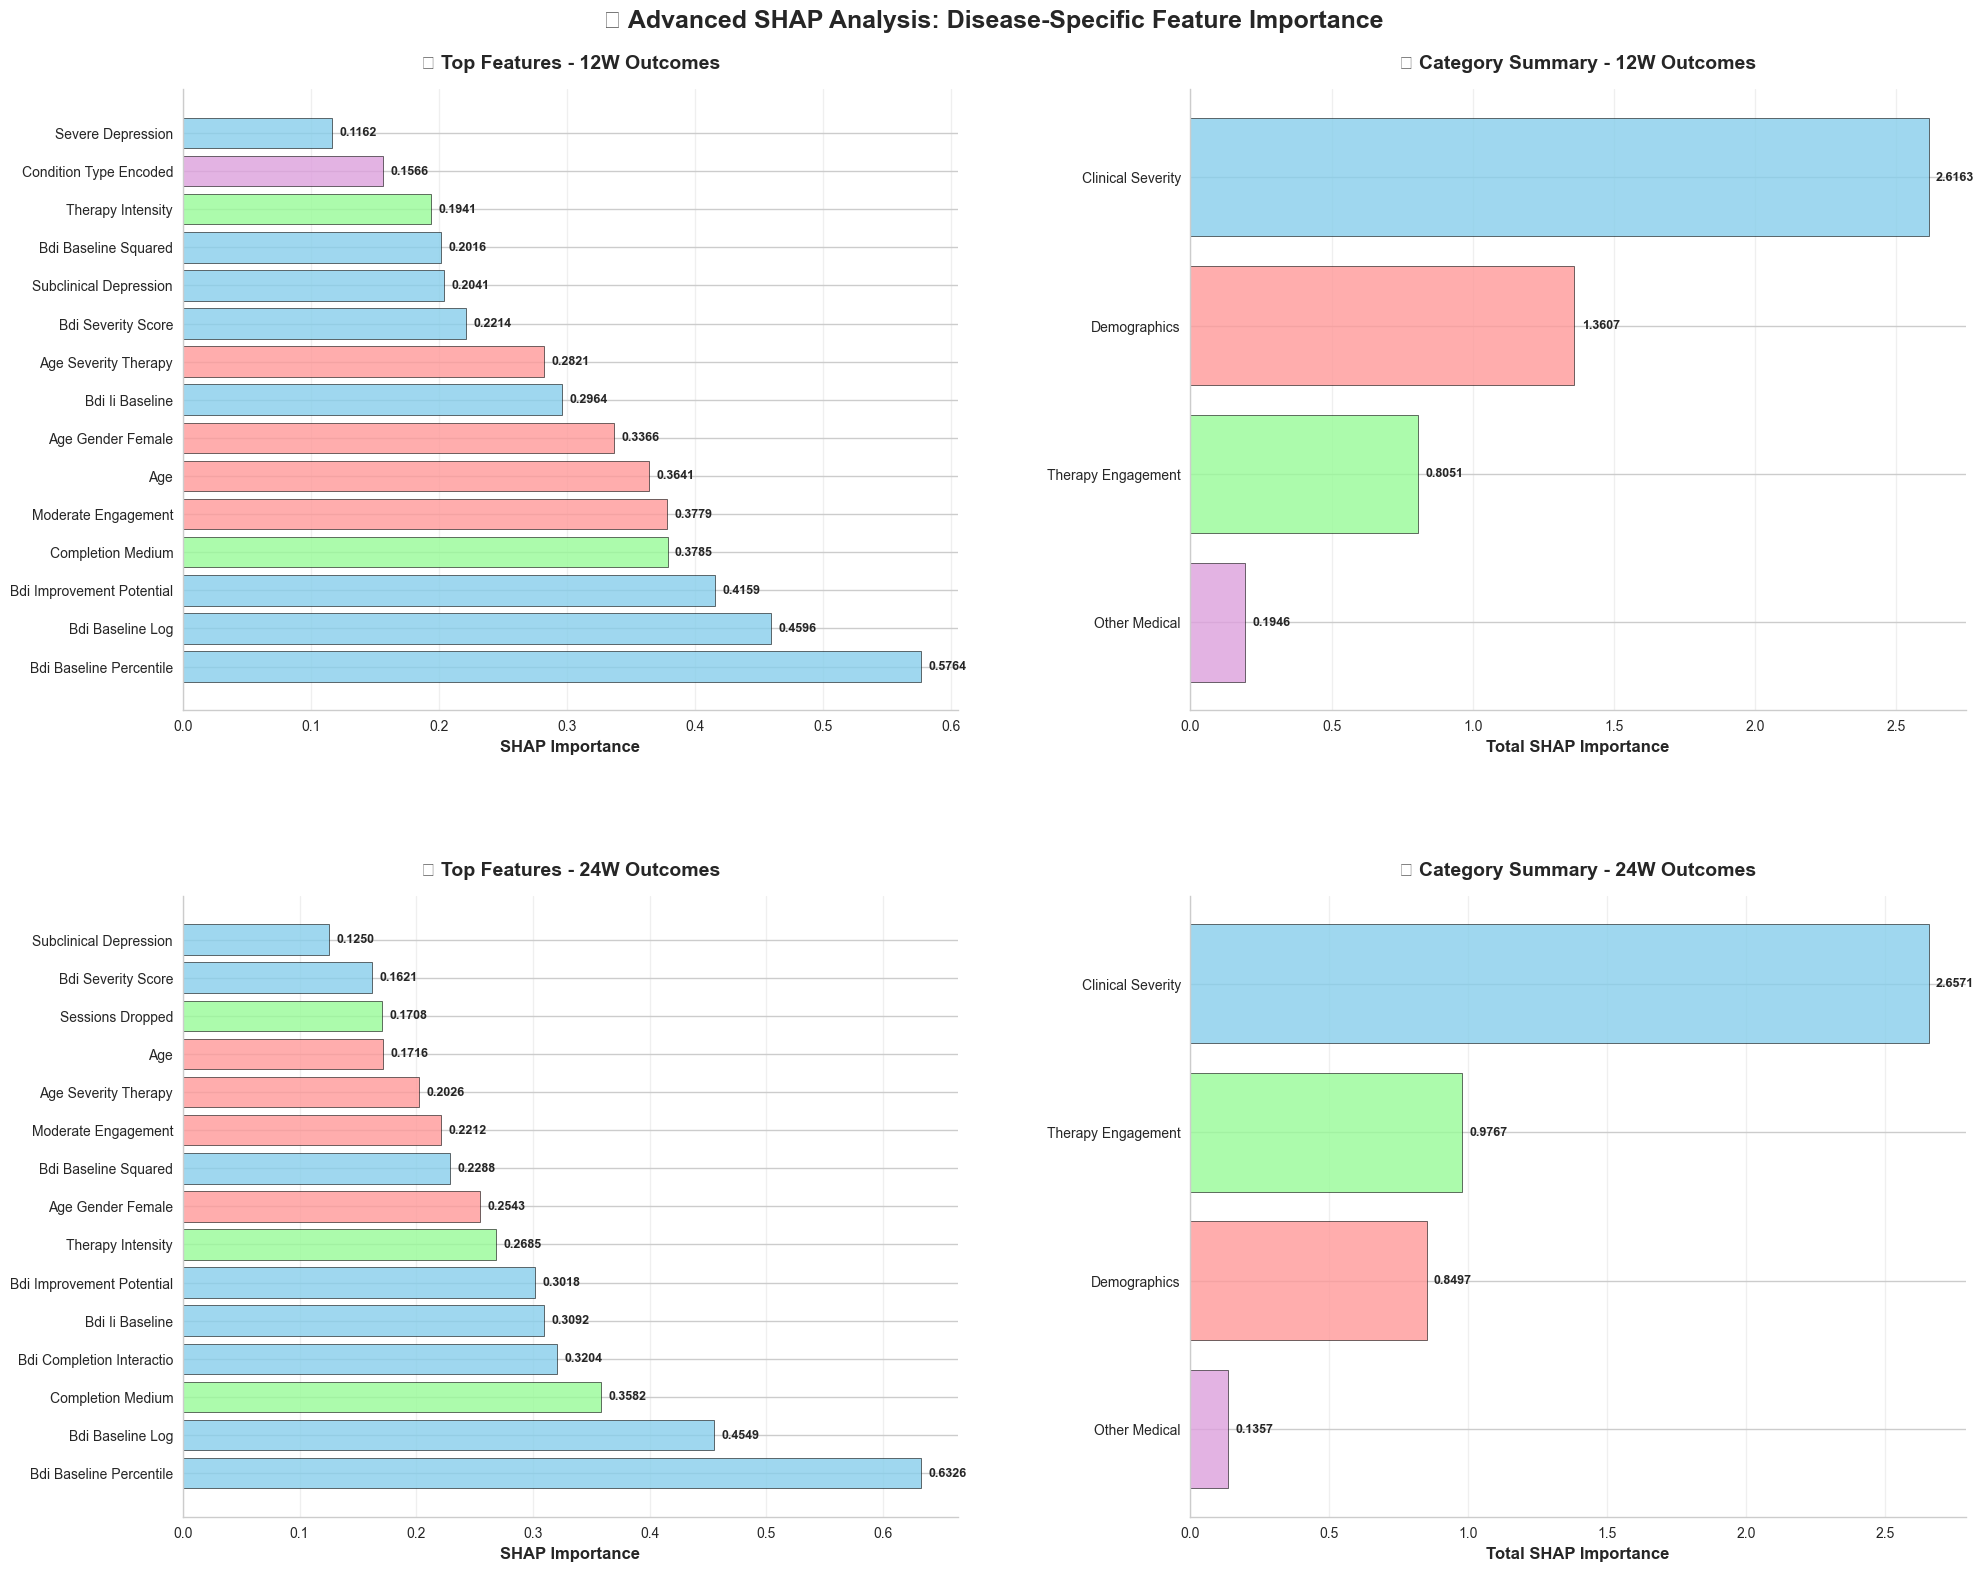

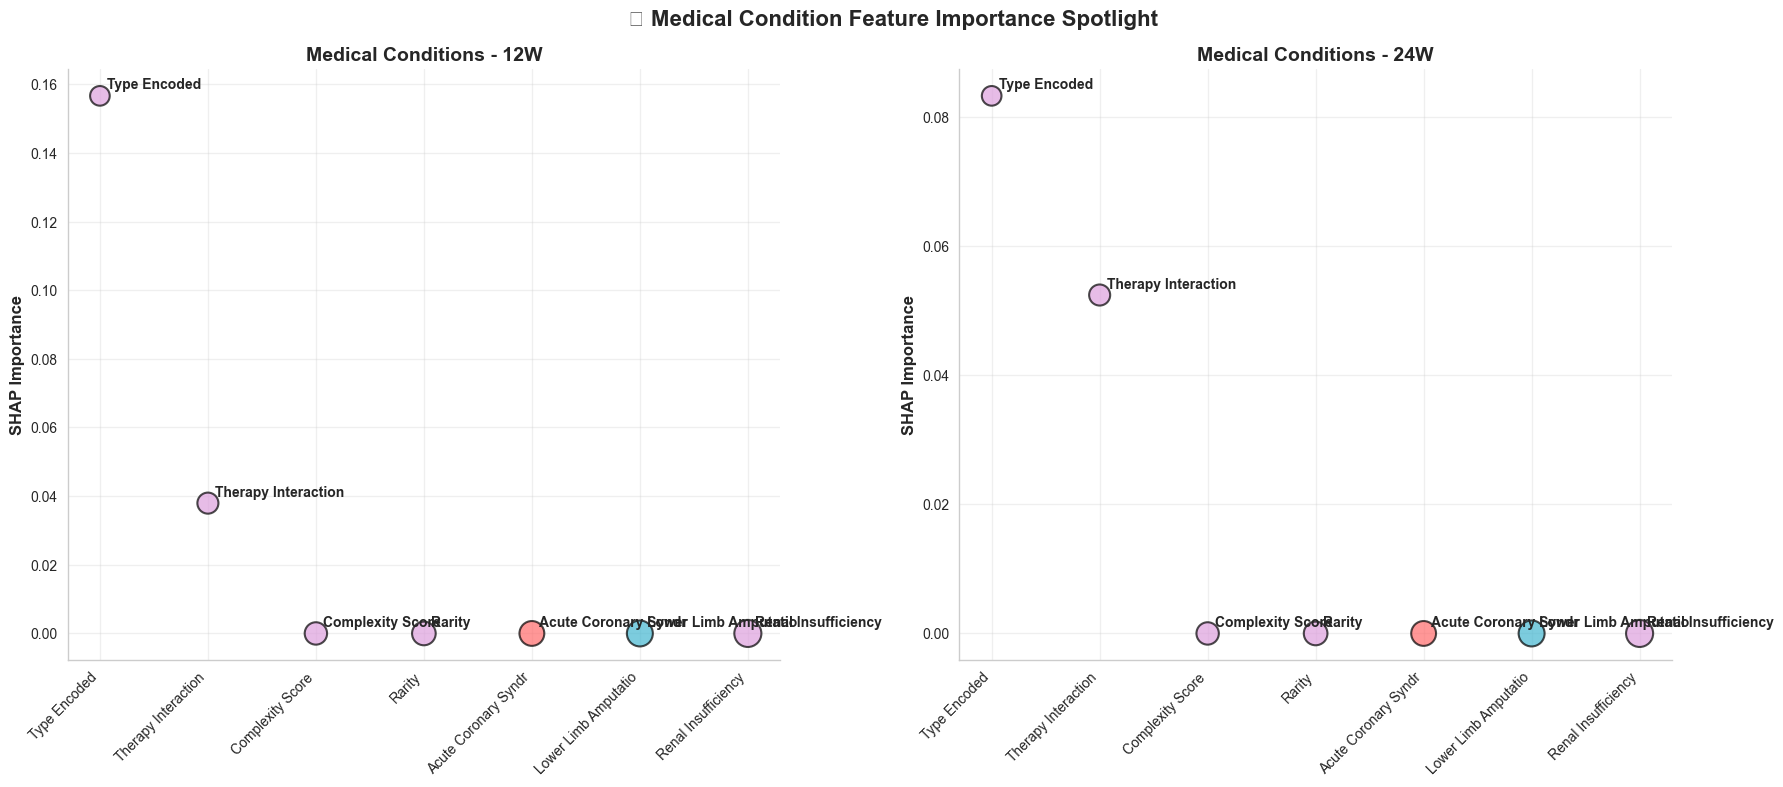

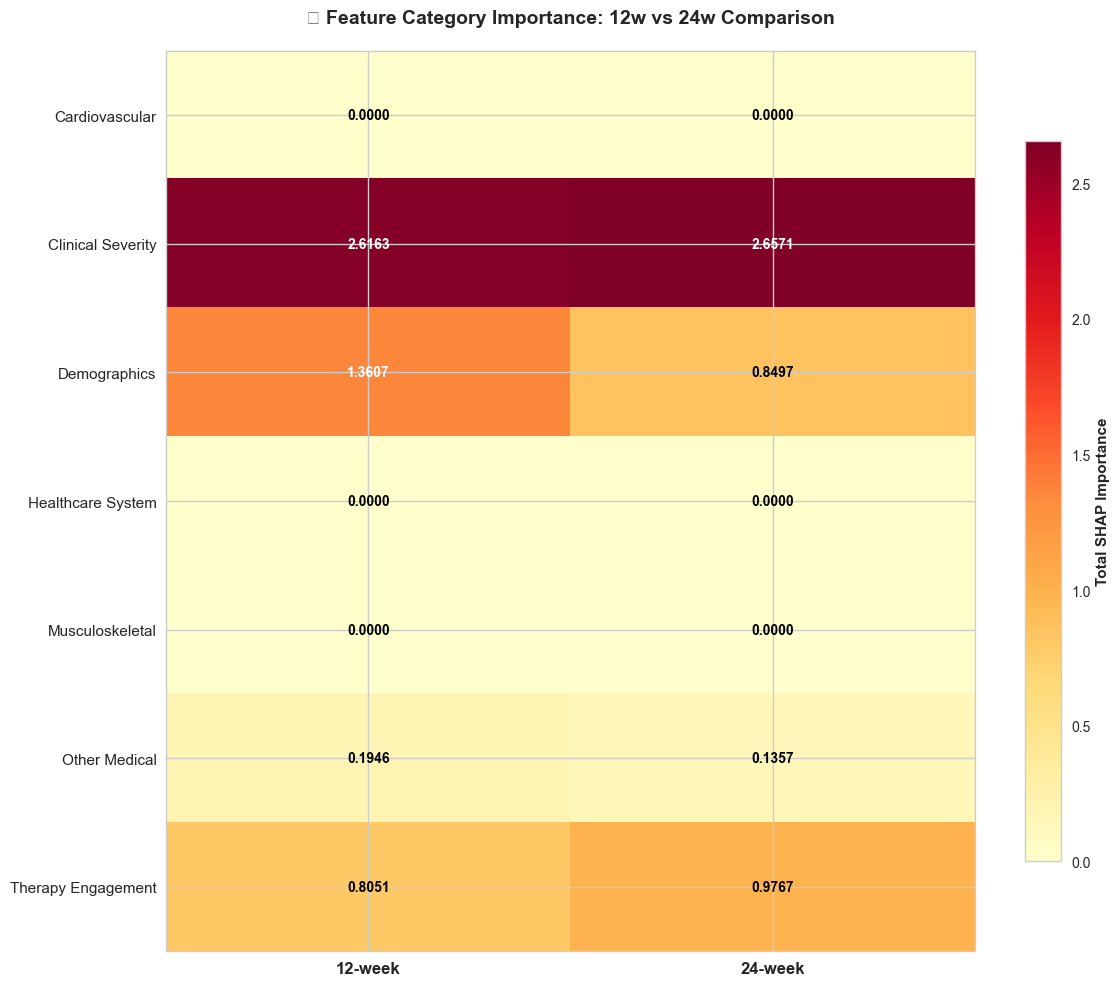

📊 Beautiful static SHAP visualizations created and saved!
   📁 Files saved:
      • shap_feature_importance_static.png & .pdf
      • medical_conditions_shap_spotlight.png
      • category_comparison_heatmap.png


In [8]:
# 📊 Beautiful Static SHAP Visualizations for Disease-Specific Analysis
print("📊 Creating beautiful static SHAP visualizations...")

# Set up publication-quality plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 1. Comprehensive SHAP Feature Importance Comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('🔬 Advanced SHAP Analysis: Disease-Specific Feature Importance', 
             fontsize=18, fontweight='bold', y=0.98)

for idx, timepoint in enumerate(['12w', '24w']):
    importance_df = disease_feature_importance[timepoint]
    top_features = importance_df.head(15)
    
    # Feature Importance Bar Plot (Left column)
    ax_bar = axes[idx, 0]
    
    # Create color map based on feature categories
    category_colors = {
        'Cardiovascular': '#FF6B6B',
        'Metabolic': '#4ECDC4', 
        'Musculoskeletal': '#45B7D1',
        'Respiratory': '#96CEB4',
        'Neurological': '#FFEAA7',
        'Other Medical': '#DDA0DD',
        'Demographics': '#FF9999',
        'Clinical Severity': '#87CEEB',
        'Therapy Engagement': '#98FB98',
        'Healthcare System': '#F0E68C',
        'Other': '#D3D3D3'
    }
    
    colors = [category_colors.get(cat, '#D3D3D3') for cat in top_features['category']]
    
    bars = ax_bar.barh(range(len(top_features)), top_features['importance'], 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
        width = bar.get_width()
        ax_bar.text(width + max(top_features['importance'])*0.01, 
                   bar.get_y() + bar.get_height()/2.,
                   f'{importance:.4f}', ha='left', va='center', 
                   fontweight='bold', fontsize=9)
    
    # Clean feature names for display
    clean_names = [name.replace('_', ' ').title()[:25] for name in top_features['feature']]
    ax_bar.set_yticks(range(len(top_features)))
    ax_bar.set_yticklabels(clean_names)
    ax_bar.set_xlabel('SHAP Importance', fontsize=12, fontweight='bold')
    ax_bar.set_title(f'🎯 Top Features - {timepoint.upper()} Outcomes', 
                     fontsize=14, fontweight='bold', pad=15)
    ax_bar.grid(axis='x', alpha=0.3)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    
    # Category Summary (Right column)
    ax_cat = axes[idx, 1]
    category_summary = importance_df.groupby('category')['importance'].agg(['mean', 'sum', 'count'])
    category_summary = category_summary.sort_values('sum', ascending=True)
    
    # Filter out categories with very low importance
    category_summary = category_summary[category_summary['sum'] > 0.001]
    
    colors_cat = [category_colors.get(cat, '#D3D3D3') for cat in category_summary.index]
    
    bars_cat = ax_cat.barh(range(len(category_summary)), category_summary['sum'], 
                          color=colors_cat, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for i, (bar, total_imp) in enumerate(zip(bars_cat, category_summary['sum'])):
        width = bar.get_width()
        ax_cat.text(width + max(category_summary['sum'])*0.01, 
                   bar.get_y() + bar.get_height()/2.,
                   f'{total_imp:.4f}', ha='left', va='center', 
                   fontweight='bold', fontsize=9)
    
    ax_cat.set_yticks(range(len(category_summary)))
    ax_cat.set_yticklabels(category_summary.index)
    ax_cat.set_xlabel('Total SHAP Importance', fontsize=12, fontweight='bold')
    ax_cat.set_title(f'📊 Category Summary - {timepoint.upper()} Outcomes', 
                     fontsize=14, fontweight='bold', pad=15)
    ax_cat.grid(axis='x', alpha=0.3)
    ax_cat.spines['top'].set_visible(False)
    ax_cat.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)
plt.savefig(FIGURES_PATH / "shap_feature_importance_static.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig(FIGURES_PATH / "shap_feature_importance_static.pdf", 
            bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

# 2. Medical Condition Focus Visualization
fig2, axes2 = plt.subplots(1, 2, figsize=(18, 8))
fig2.suptitle('🏥 Medical Condition Feature Importance Spotlight', 
              fontsize=16, fontweight='bold')

for idx, timepoint in enumerate(['12w', '24w']):
    ax = axes2[idx]
    importance_df = disease_feature_importance[timepoint]
    
    # Filter for medical condition features only
    medical_features = importance_df[
        importance_df['category'].str.contains('Medical|Cardiovascular|Metabolic|Musculoskeletal|Respiratory|Neurological')
    ]
    
    if not medical_features.empty:
        # Clean condition names
        condition_names = []
        for feature in medical_features['feature']:
            clean_name = feature.replace('condition_', '').replace('_', ' ').title()
            condition_names.append(clean_name[:20])
        
        # Create bubble chart effect
        ax.scatter(range(len(medical_features)), medical_features['importance'],
                  s=[200 + i*30 for i in range(len(medical_features))], 
                  c=[category_colors.get(cat, '#D3D3D3') for cat in medical_features['category']],
                  alpha=0.7, edgecolors='black', linewidth=1.5)
        
        # Add feature labels
        for i, (name, importance) in enumerate(zip(condition_names, medical_features['importance'])):
            ax.annotate(name, (i, importance), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=10, fontweight='bold', ha='left')
        
        ax.set_xticks(range(len(medical_features)))
        ax.set_xticklabels(condition_names, rotation=45, ha='right')
        ax.set_ylabel('SHAP Importance', fontsize=12, fontweight='bold')
        ax.set_title(f'Medical Conditions - {timepoint.upper()}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.text(0.5, 0.5, 'No medical condition features\nwith significant importance', 
               ha='center', va='center', transform=ax.transAxes, 
               fontsize=12, fontweight='bold')
        ax.set_title(f'Medical Conditions - {timepoint.upper()}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / "medical_conditions_shap_spotlight.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

# 3. Feature Category Comparison Heatmap
categories_12w = disease_feature_importance['12w'].groupby('category')['importance'].sum()
categories_24w = disease_feature_importance['24w'].groupby('category')['importance'].sum()

# Combine and create comparison matrix
all_categories = sorted(set(categories_12w.index) | set(categories_24w.index))
comparison_matrix = np.zeros((len(all_categories), 2))

for i, category in enumerate(all_categories):
    comparison_matrix[i, 0] = categories_12w.get(category, 0)
    comparison_matrix[i, 1] = categories_24w.get(category, 0)

fig3, ax3 = plt.subplots(1, 1, figsize=(12, 10))
im = ax3.imshow(comparison_matrix, cmap='YlOrRd', aspect='auto')

ax3.set_xticks([0, 1])
ax3.set_xticklabels(['12-week', '24-week'], fontsize=12, fontweight='bold')
ax3.set_yticks(range(len(all_categories)))
ax3.set_yticklabels(all_categories, fontsize=11)

# Add text annotations
for i in range(len(all_categories)):
    for j in range(2):
        text = ax3.text(j, i, f'{comparison_matrix[i, j]:.4f}',
                       ha="center", va="center", 
                       color="white" if comparison_matrix[i, j] > comparison_matrix.max()/2 else "black",
                       fontweight='bold', fontsize=10)

ax3.set_title('📊 Feature Category Importance: 12w vs 24w Comparison', 
              fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Total SHAP Importance', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / "category_comparison_heatmap.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("📊 Beautiful static SHAP visualizations created and saved!")
print(f"   📁 Files saved:")
print(f"      • shap_feature_importance_static.png & .pdf")
print(f"      • medical_conditions_shap_spotlight.png")
print(f"      • category_comparison_heatmap.png")

🔬 Conducting individual medical condition deep-dive analysis...

🔍 Analyzing: Complexity Score
   ✅ Analysis completed - Sample size: 80

🔍 Analyzing: Type Encoded
   ⚠️ Insufficient sample size for SHAP analysis

🔍 Analyzing: Therapy Interaction
   ⚠️ Insufficient sample size for SHAP analysis

🔍 Analyzing: Acute Coronary Syndrome
   ⚠️ Insufficient sample size for SHAP analysis

🔍 Analyzing: Lower Limb Amputation
   ⚠️ Insufficient sample size for SHAP analysis

🔍 Analyzing: Renal Insufficiency
   ⚠️ Insufficient sample size for SHAP analysis
📊 Creating comprehensive static disease-specific analysis visualization...


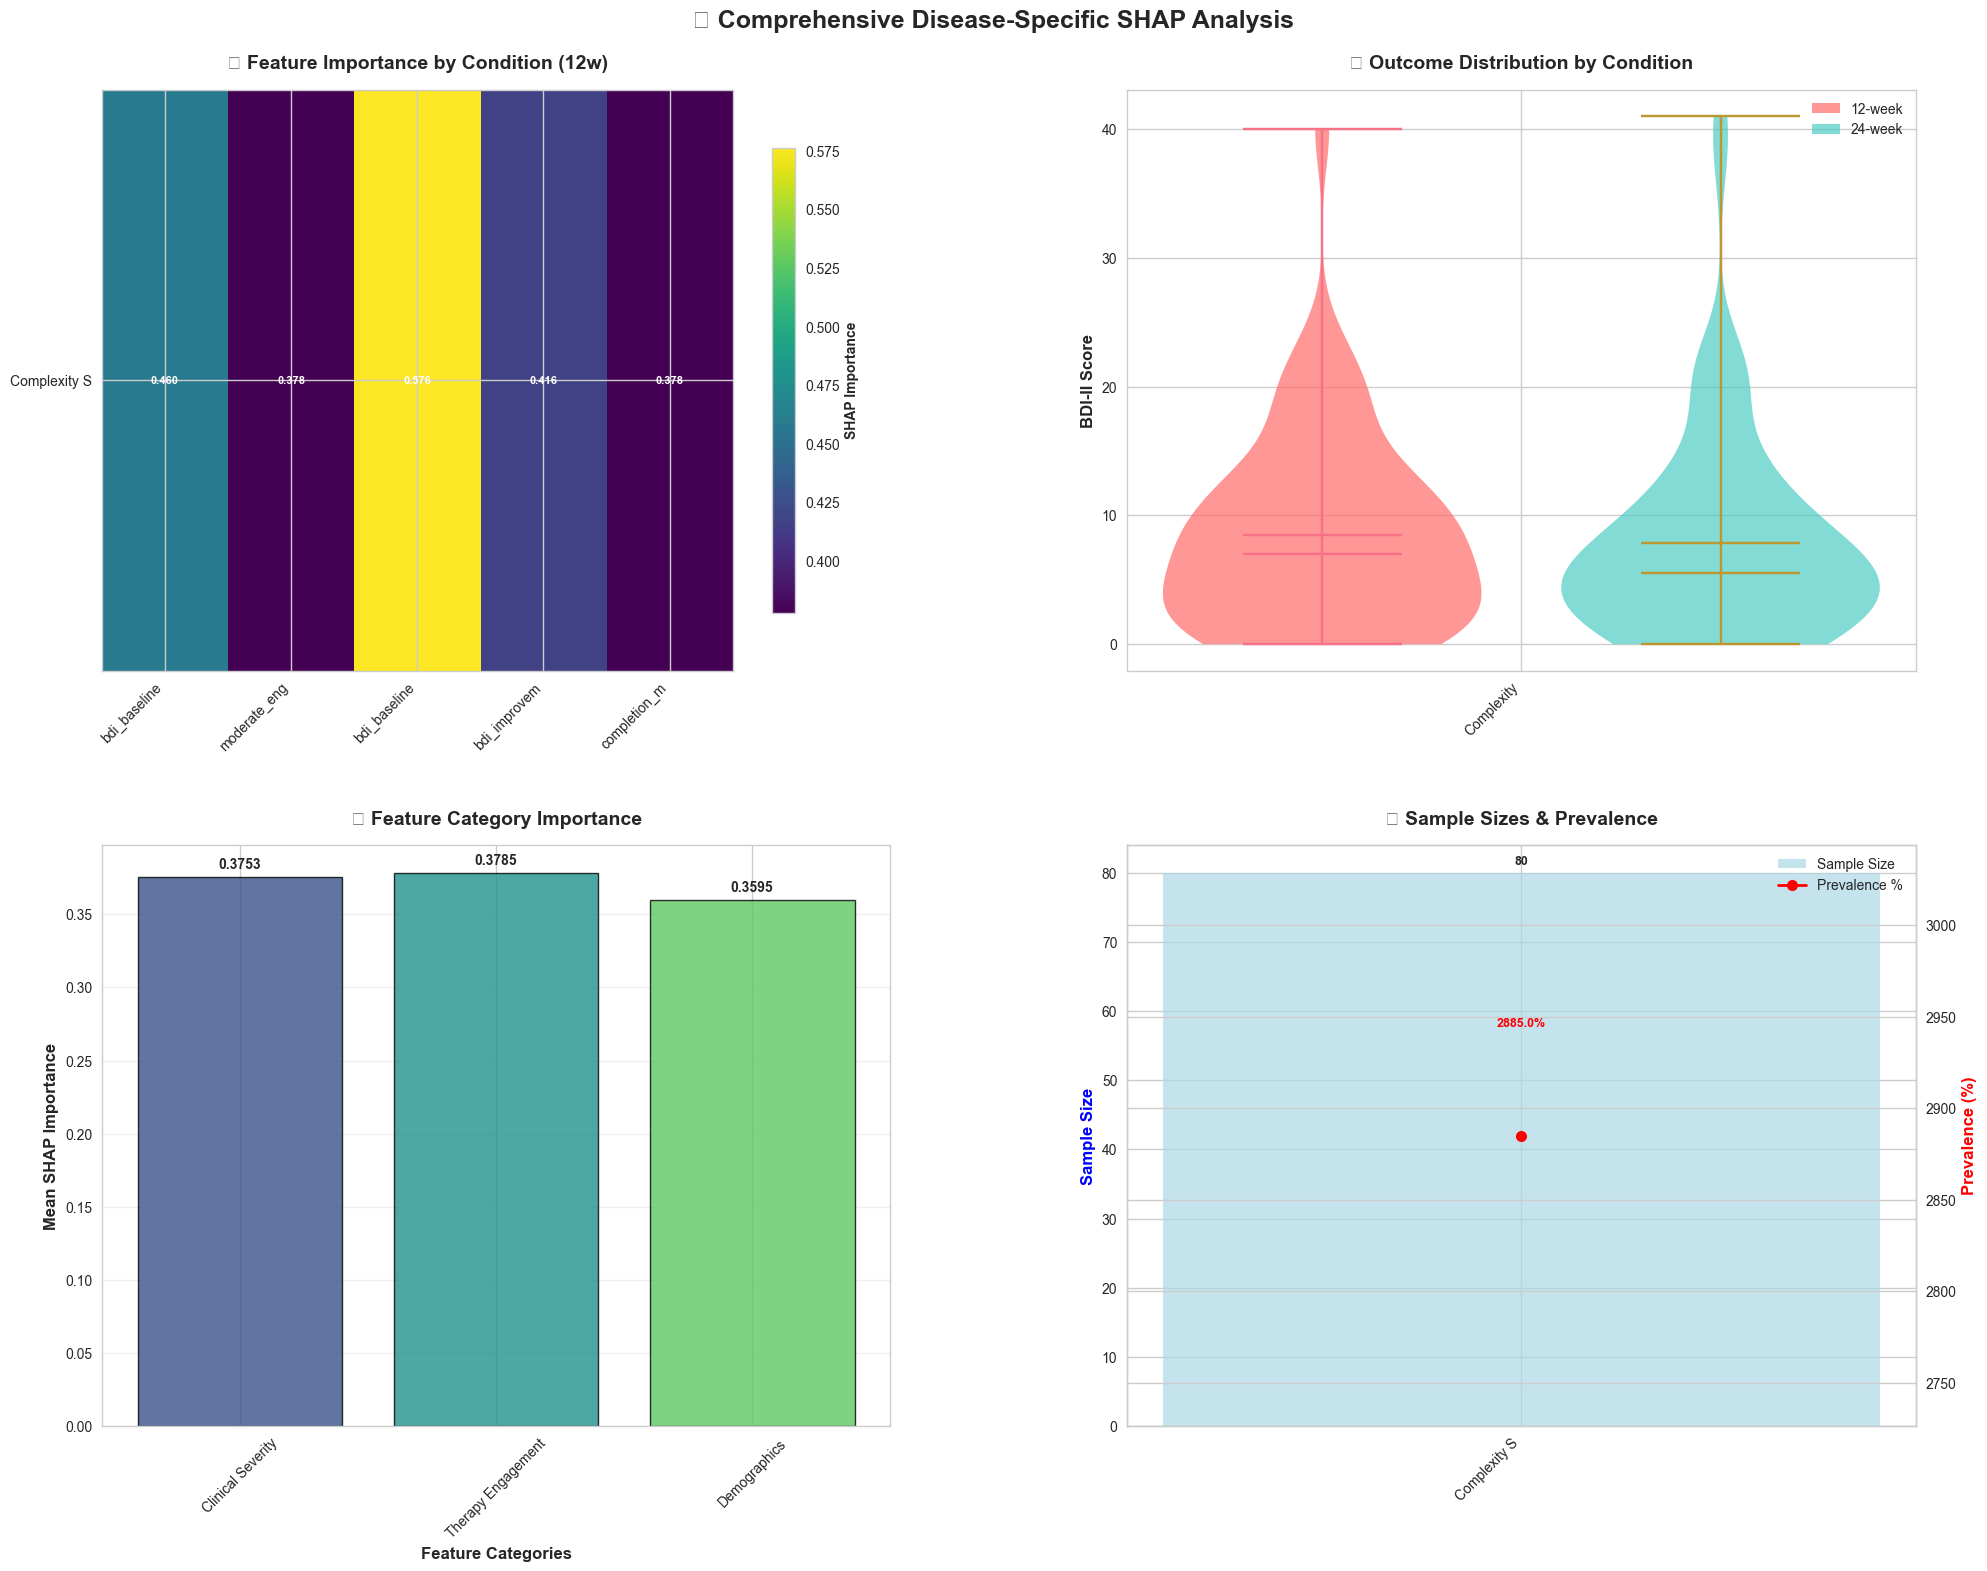

📊 Beautiful static disease-specific analysis visualization created and saved!
   📁 Saved as: disease_specific_comprehensive_analysis_static.png & .pdf

✅ Individual medical condition analysis completed!


In [15]:
# 🔬 Individual Medical Condition Deep-Dive Analysis
print("🔬 Conducting individual medical condition deep-dive analysis...")

# Select top medical conditions for detailed analysis
top_conditions = prevalence_df.head(8).index.tolist()
condition_detailed_analysis = {}

for condition in top_conditions:
    if condition_prevalence[condition]['count'] >= 10:  # Minimum sample size
        print(f"\n🔍 Analyzing: {condition.replace('condition_', '').replace('_', ' ').title()}")
        
        # Subset data for this condition
        has_condition = train_data[condition] == 1
        condition_subset = train_data[has_condition]
        
        # SHAP analysis for patients with this condition
        condition_indices = has_condition[has_condition].index
        available_indices = [i for i in condition_indices if i < len(X_explain)]
        
        if len(available_indices) >= 5:  # Minimum for SHAP analysis
            condition_X = X_explain[available_indices]
            
            # Get SHAP values for this condition subset
            condition_shap_12w = disease_shap_values['12w'].values[available_indices]
            condition_shap_24w = disease_shap_values['24w'].values[available_indices]
            
            # Calculate condition-specific feature importance
            condition_importance_12w = np.abs(condition_shap_12w).mean(axis=0)
            condition_importance_24w = np.abs(condition_shap_24w).mean(axis=0)
            
            # Create condition-specific importance dataframes
            condition_df_12w = pd.DataFrame({
                'feature': feature_cols,
                'importance': condition_importance_12w
            }).sort_values('importance', ascending=False)
            
            condition_df_24w = pd.DataFrame({
                'feature': feature_cols,
                'importance': condition_importance_24w
            }).sort_values('importance', ascending=False)
            
            # Store results
            condition_detailed_analysis[condition] = {
                'name': condition.replace('condition_', '').replace('_', ' ').title(),
                'sample_size': len(available_indices),
                'importance_12w': condition_df_12w,
                'importance_24w': condition_df_24w,
                'outcomes_12w': condition_subset['bdi_ii_after_intervention_12w'].describe(),
                'outcomes_24w': condition_subset['bdi_ii_follow_up_24w'].describe(),
                'improvement_12w': condition_subset['improvement_12w'].describe(),
                'improvement_24w': condition_subset['improvement_24w'].describe()
            }
            
            print(f"   ✅ Analysis completed - Sample size: {len(available_indices)}")
        else:
            print(f"   ⚠️ Insufficient sample size for SHAP analysis")

# Create beautiful static condition comparison visualization
if condition_detailed_analysis:
    print("📊 Creating comprehensive static disease-specific analysis visualization...")
    
    # Set up publication-quality plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Prepare data for comparison
    conditions_analyzed = list(condition_detailed_analysis.keys())[:6]  # Top 6 for visualization
    
    # Create comprehensive 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('🔬 Comprehensive Disease-Specific SHAP Analysis', fontsize=18, fontweight='bold', y=0.98)
    
    # 1. Top features by condition comparison (Top left)
    ax1 = axes[0, 0]
    
    # Collect top features for all conditions
    all_condition_features = {}
    condition_labels = []
    
    for condition in conditions_analyzed:
        condition_name = condition_detailed_analysis[condition]['name'][:12]
        top_features_12w = condition_detailed_analysis[condition]['importance_12w'].head(8)
        
        # Store for visualization
        all_condition_features[condition_name] = top_features_12w
        condition_labels.append(condition_name)
    
    # Create grouped bar chart for top features
    if all_condition_features:
        # Get union of all top features
        all_top_features = set()
        for condition_features in all_condition_features.values():
            all_top_features.update(condition_features['feature'].head(5))
        
        all_top_features = list(all_top_features)[:8]  # Limit for readability
        
        # Create matrix for heatmap-style visualization
        importance_matrix = []
        for condition_name in condition_labels:
            row = []
            for feature in all_top_features:
                importance_df = all_condition_features[condition_name]
                feature_importance = importance_df[importance_df['feature'] == feature]['importance']
                row.append(feature_importance.iloc[0] if len(feature_importance) > 0 else 0)
            importance_matrix.append(row)
        
        # Create heatmap
        im1 = ax1.imshow(importance_matrix, cmap='viridis', aspect='auto')
        ax1.set_xticks(range(len(all_top_features)))
        ax1.set_yticks(range(len(condition_labels)))
        ax1.set_xticklabels([f[:12] for f in all_top_features], rotation=45, ha='right')
        ax1.set_yticklabels(condition_labels)
        
        # Add text annotations
        for i in range(len(condition_labels)):
            for j in range(len(all_top_features)):
                text = ax1.text(j, i, f'{importance_matrix[i][j]:.3f}',
                               ha="center", va="center", 
                               color="white" if importance_matrix[i][j] > max(max(row) for row in importance_matrix)/2 else "black",
                               fontweight='bold', fontsize=8)
        
        ax1.set_title('🎯 Feature Importance by Condition (12w)', fontsize=14, fontweight='bold', pad=15)
        
        # Add colorbar
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
        cbar1.set_label('SHAP Importance', fontsize=10, fontweight='bold')
    
    # 2. Outcome comparison by condition (Top right)
    ax2 = axes[0, 1]
    
    outcome_data_12w = []
    outcome_data_24w = []
    outcome_labels = []
    
    for condition in conditions_analyzed:
        condition_name = condition_detailed_analysis[condition]['name'][:10]
        
        # Get outcomes for this condition
        has_condition = train_data[condition] == 1
        outcomes_12w = train_data[has_condition]['bdi_ii_after_intervention_12w'].dropna()
        outcomes_24w = train_data[has_condition]['bdi_ii_follow_up_24w'].dropna()
        
        if len(outcomes_12w) > 3 and len(outcomes_24w) > 3:
            outcome_data_12w.append(outcomes_12w.values)
            outcome_data_24w.append(outcomes_24w.values)
            outcome_labels.append(condition_name)
    
    # Create violin plots for better visualization
    if outcome_data_12w:
        positions_12w = np.arange(1, len(outcome_labels)*2, 2)
        positions_24w = np.arange(2, len(outcome_labels)*2+1, 2)
        
        violin_parts_12w = ax2.violinplot(outcome_data_12w, positions=positions_12w, 
                                         widths=0.8, showmeans=True, showmedians=True)
        violin_parts_24w = ax2.violinplot(outcome_data_24w, positions=positions_24w, 
                                         widths=0.8, showmeans=True, showmedians=True)
        
        # Color the violins
        for pc in violin_parts_12w['bodies']:
            pc.set_facecolor('#FF6B6B')
            pc.set_alpha(0.7)
        
        for pc in violin_parts_24w['bodies']:
            pc.set_facecolor('#4ECDC4')
            pc.set_alpha(0.7)
        
        ax2.set_xticks(np.arange(1.5, len(outcome_labels)*2, 2))
        ax2.set_xticklabels(outcome_labels, rotation=45, ha='right')
        ax2.set_ylabel('BDI-II Score', fontsize=12, fontweight='bold')
        ax2.set_title('📊 Outcome Distribution by Condition', fontsize=14, fontweight='bold', pad=15)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.7, label='12-week'),
                          Patch(facecolor='#4ECDC4', alpha=0.7, label='24-week')]
        ax2.legend(handles=legend_elements, loc='upper right')
    
    # 3. Feature category importance (Bottom left)
    ax3 = axes[1, 0]
    
    # Aggregate importance by feature categories
    category_importance = {}
    for condition in conditions_analyzed:
        importance_12w = condition_detailed_analysis[condition]['importance_12w']
        
        # Categorize features
        for _, row in importance_12w.head(10).iterrows():
            feature = row['feature']
            importance = row['importance']
            
            if 'condition' in feature.lower():
                category = 'Medical Conditions'
            elif any(term in feature.lower() for term in ['bdi', 'depression', 'severity']):
                category = 'Clinical Severity'
            elif any(term in feature.lower() for term in ['therapy', 'completion', 'session']):
                category = 'Therapy Engagement'
            elif any(term in feature.lower() for term in ['age', 'gender']):
                category = 'Demographics'
            else:
                category = 'Other'
            
            if category not in category_importance:
                category_importance[category] = []
            category_importance[category].append(importance)
    
    # Calculate mean importance per category
    category_means = {cat: np.mean(values) for cat, values in category_importance.items()}
    
    if category_means:
        categories = list(category_means.keys())
        means = list(category_means.values())
        
        bars = ax3.bar(categories, means, color=sns.color_palette("viridis", len(categories)),
                       alpha=0.8, edgecolor='black', linewidth=1)
        
        # Add value labels
        for bar, mean_val in zip(bars, means):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + max(means)*0.01,
                     f'{mean_val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax3.set_xlabel('Feature Categories', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Mean SHAP Importance', fontsize=12, fontweight='bold')
        ax3.set_title('📈 Feature Category Importance', fontsize=14, fontweight='bold', pad=15)
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(axis='y', alpha=0.3)
    
    # 4. Condition sample sizes and prevalence (Bottom right)
    ax4 = axes[1, 1]
    
    condition_names = []
    sample_sizes = []
    prevalence_rates = []
    
    for condition in conditions_analyzed:
        condition_name = condition_detailed_analysis[condition]['name'][:12]
        sample_size = condition_detailed_analysis[condition]['sample_size']
        prevalence_rate = condition_prevalence[condition]['percentage']
        
        condition_names.append(condition_name)
        sample_sizes.append(sample_size)
        prevalence_rates.append(prevalence_rate)
    
    # Create dual-axis plot
    ax4_twin = ax4.twinx()
    
    # Bar chart for sample sizes
    bars = ax4.bar(range(len(condition_names)), sample_sizes, 
                   color='lightblue', alpha=0.7, label='Sample Size')
    
    # Line plot for prevalence rates
    line = ax4_twin.plot(range(len(condition_names)), prevalence_rates, 
                        color='red', marker='o', linewidth=2, markersize=8, 
                        label='Prevalence %')
    
    ax4.set_xticks(range(len(condition_names)))
    ax4.set_xticklabels(condition_names, rotation=45, ha='right')
    ax4.set_ylabel('Sample Size', fontsize=12, fontweight='bold', color='blue')
    ax4_twin.set_ylabel('Prevalence (%)', fontsize=12, fontweight='bold', color='red')
    ax4.set_title('📊 Sample Sizes & Prevalence', fontsize=14, fontweight='bold', pad=15)
    
    # Add value labels
    for i, (bar, size, prev) in enumerate(zip(bars, sample_sizes, prevalence_rates)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(sample_sizes)*0.01,
                 f'{size}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        ax4_twin.text(i, prev + max(prevalence_rates)*0.02,
                     f'{prev:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9, color='red')
    
    # Combine legends
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)
    
    # Save the comprehensive analysis
    plt.savefig(FIGURES_PATH / "disease_specific_comprehensive_analysis_static.png", 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.savefig(FIGURES_PATH / "disease_specific_comprehensive_analysis_static.pdf", 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    
    plt.show()
    
    print("📊 Beautiful static disease-specific analysis visualization created and saved!")
    print(f"   📁 Saved as: disease_specific_comprehensive_analysis_static.png & .pdf")

print("\n✅ Individual medical condition analysis completed!")